In [28]:
# Install required packages for models and analysis
# Run this cell once in the notebook kernel to ensure all model libraries are available.
import sys
print(f"Using Python executable: {sys.executable}")
# The list below includes common ML libraries used in this notebook: sklearn, imbalanced-learn, xgboost, lightgbm,
# pytorch-tabnet, torch, tensorflow, shap (for explainability), and category_encoders (if needed).
# Adjust the list if your environment already provides some packages (to avoid re-installing large packages like torch/tensorflow).
!{sys.executable} -m pip install --upgrade pip -q
!{sys.executable} -m pip install -q scikit-learn imbalanced-learn xgboost lightgbm pytorch-tabnet torch tensorflow shap category_encoders optuna
print('Install command completed. If you need GPU-optimized torch/tensorflow, install the appropriate build for your environment.')

Using Python executable: /home/codespace/.python/current/bin/python


Install command completed. If you need GPU-optimized torch/tensorflow, install the appropriate build for your environment.


# Insurance Renewal Prediction— Complete Notebook

This notebook contains EDA, feature engineering, model training, interpretability (SHAP), comprehensive evaluation, and reporting. Run cells sequentially. Heavy cells are guarded.


### 1. Imports & environment

In [29]:

import os, time, warnings, random
warnings.filterwarnings('ignore')
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
sns.set(style='whitegrid')
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Make dirs
os.makedirs('Visualizations', exist_ok=True)
os.makedirs('Visualizations/Results', exist_ok=True)

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

print('Environment ready.')

# Create additional visualization folders used by the old notebook helpers
os.makedirs('Visualizations/Plots', exist_ok=True)
os.makedirs('Visualizations/Feature_Importance', exist_ok=True)
os.makedirs('Visualizations/Results', exist_ok=True)
# Lightweight helper to save plots consistently
def save_plot(plt_obj, name, folder='Visualizations/Plots', tight=True):
    if tight:
        try:
            plt_obj.tight_layout()
        except Exception:
            pass
    path = os.path.join(folder, f'{name}.png')
    try:
        plt_obj.savefig(path, dpi=300, bbox_inches='tight')
    except Exception:
        plt_obj.savefig(path)
    try:
        plt_obj.close()
    except Exception:
        pass
    print(f'Saved plot: {path}')

def plot_and_save(plot_func, name, *args, folder='Visualizations/Plots', **kwargs):
    import matplotlib.pyplot as _plt
    _plt.figure(figsize=kwargs.pop('figsize', (10,6)))
    plot_func(*args, **kwargs)
    save_plot(_plt, name, folder=folder)

# Define output paths for results and visualizations
OUTPUT_PATHS = {
    'metrics': os.path.join('Visualizations','Results','model_comparison_metrics.csv'),
    'mutual_info': os.path.join('Visualizations','Results','mutual_info_scores.csv'),
    'target_dist': os.path.join('Visualizations','Results','target_distribution_normalized.csv'),
    'plots': {
        'roc': os.path.join('Visualizations','Plots','roc_curves_comparison.png'),
        'pr': os.path.join('Visualizations','Plots','precision_recall_curves.png'),
        'feature_importance': os.path.join('Visualizations','Feature_Importance','feature_importance_comparison.png')
    },
    'predictions': {
        'lr': os.path.join('Visualizations','Results','lr_predictions.csv'),
        'xgb': os.path.join('Visualizations','Results','xgb_predictions.csv'),
        'nn': os.path.join('Visualizations','Results','nn_predictions.csv'),
        'brf': os.path.join('Visualizations','Results','balanced_rf_predictions.csv'),
        'eec': os.path.join('Visualizations','Results','easy_ensemble_predictions.csv'),
        'tab': os.path.join('Visualizations','Results','tabnet_predictions.csv')
    },
    'shap_values': os.path.join('Visualizations','Results','shap_values.csv'),
    'shap_summary_png': os.path.join('Visualizations','shap_summary_plot.png'),
    'shap_bar_png': os.path.join('Visualizations','shap_bar_plot.png')
}

Environment ready.


### 2. Load data

In [30]:
# 2. Load data — support separate train/test files if present
DATA_DIR = 'Dataset'
DATA_PATH = os.path.join(DATA_DIR, 'train_ZoGVYWq.csv')

df_raw = None
# search for train/test files heuristically
train_files = []
test_files = []
if os.path.isdir(DATA_DIR):
    for fn in sorted(os.listdir(DATA_DIR)):
        low = fn.lower()
        if 'train' in low:
            train_files.append(os.path.join(DATA_DIR, fn))
        if 'test' in low:
            test_files.append(os.path.join(DATA_DIR, fn))

# Load first matching train/test if available
df_train_raw = None
df_test_raw = None
if train_files:
    try:
        df_train_raw = pd.read_csv(train_files[0])
        print('Loaded train:', train_files[0], df_train_raw.shape)
    except Exception as e:
        print('Failed to load train file', train_files[0], e)
if test_files:
    try:
        df_test_raw = pd.read_csv(test_files[0])
        print('Loaded test :', test_files[0], df_test_raw.shape)
    except Exception as e:
        print('Failed to load test file', test_files[0], e)

# Fallback: old single-file path
if df_train_raw is None:
    if os.path.exists(DATA_PATH):
        try:
            df_raw = pd.read_csv(DATA_PATH)
            print('Loaded single dataset:', DATA_PATH, df_raw.shape)
        except Exception as e:
            print('Failed to load DATA_PATH:', DATA_PATH, e)
    else:
        df_raw = None
        print('No dataset found in Dataset directory.')
else:
    # keep df_raw for backward compatibility pointing to train
    df_raw = df_train_raw.copy()


Loaded train: Dataset/train_ZoGVYWq.csv (79853, 13)
Loaded test : Dataset/test_66516Ee.csv (34224, 12)
Loaded test : Dataset/test_66516Ee.csv (34224, 12)


## 3. Exploratory Data Analysis (EDA)
Includes missing value heatmap, target distribution, numeric distributions, categorical counts, correlation heatmap.

In [31]:
# EDA: quick overview + missing values heatmap
if df_raw is None:
    print('No data for EDA.')
else:
    display(df_raw.head())
    print('\nColumns:', df_raw.columns.tolist())
    print('\nMissing values per column:')
    print(df_raw.isnull().sum().sort_values(ascending=False).head(20))
    # Missing heatmap (sample if large)
    try:
        plt.figure(figsize=(10,6))
        sns.heatmap(df_raw.isnull(), cbar=False, cmap='viridis')
        plt.title('Missing Value Heatmap')
        save_plot(plt, 'missing_values_heatmap')
    except Exception as e:
        print('Missing-heatmap failed:', e)


,id,perc_premium_paid_by_cash_credit,age_in_days,Income,Count_3-6_months_late,Count_6-12_months_late,Count_more_than_12_months_late,application_underwriting_score,no_of_premiums_paid,sourcing_channel,residence_area_type,premium,renewal
0,110936,0.429,12058,355060,0.0,0.0,0.0,99.02,13,C,Urban,3300,1
1,41492,0.010,21546,315150,0.0,0.0,0.0,99.89,21,A,Urban,18000,1
2,31300,0.917,17531,84140,2.0,3.0,1.0,98.69,7,C,Rural,3300,0
3,19415,0.049,15341,250510,0.0,0.0,0.0,99.57,9,A,Urban,9600,1
4,99379,0.052,31400,198680,0.0,0.0,0.0,99.87,12,B,Urban,9600,1



Columns: ['id', 'perc_premium_paid_by_cash_credit', 'age_in_days', 'Income', 'Count_3-6_months_late', 'Count_6-12_months_late', 'Count_more_than_12_months_late', 'application_underwriting_score', 'no_of_premiums_paid', 'sourcing_channel', 'residence_area_type', 'premium', 'renewal']

Missing values per column:
application_underwriting_score      2974
Count_6-12_months_late                97
Count_more_than_12_months_late        97
Count_3-6_months_late                 97
id                                     0
Income                                 0
age_in_days                            0
perc_premium_paid_by_cash_credit       0
no_of_premiums_paid                    0
sourcing_channel                       0
residence_area_type                    0
premium                                0
renewal                                0
dtype: int64
Saved plot: Visualizations/Plots/missing_values_heatmap.png
Saved plot: Visualizations/Plots/missing_values_heatmap.png


In [32]:
# Target distribution and class imbalance
if df_raw is not None and 'renewal' in df_raw.columns:
    print('Target distribution:')
    print(df_raw['renewal'].value_counts(dropna=False))
    plt.figure(figsize=(5,3))
    sns.countplot(x='renewal', data=df_raw)
    plt.title('Target Distribution (renewal)')
    save_plot(plt, 'target_distribution')
else:
    print('renewal column not present.')    


Target distribution:
renewal
1    74855
0     4998
Name: count, dtype: int64
Saved plot: Visualizations/Plots/target_distribution.png
Saved plot: Visualizations/Plots/target_distribution.png


In [33]:
# Target distribution (normalized) - raw vs cleaned
print('\nTarget distribution (normalized):')
try:
    if df_raw is not None and 'renewal' in df_raw.columns:
        print('\nRaw data:')
        print(df_raw['renewal'].value_counts(normalize=True).round(4))
    else:
        print('\nRaw distribution: df_raw not available or no renewal column')
except Exception as e:
    print('Raw target distribution check failed:', e)

try:
    if df is not None and 'renewal' in df.columns:
        print('\nCleaned data (post-engineering):')
        print(df['renewal'].value_counts(normalize=True).round(4))
    else:
        print('\nCleaned distribution: df not available or no renewal column')
except Exception as e:
    print('Cleaned target distribution check failed:', e)

# Save numbers for reporting
try:
    out = {}
    if df_raw is not None and 'renewal' in df_raw.columns:
        out['raw'] = df_raw['renewal'].value_counts(normalize=True).to_dict()
    if df is not None and 'renewal' in df.columns:
        out['clean'] = df['renewal'].value_counts(normalize=True).to_dict()
    if out:
        pd.DataFrame(out).to_csv('Visualizations/Results/target_distribution_normalized.csv')
        print('\nSaved normalized target distribution to Visualizations/Results/target_distribution_normalized.csv')
except Exception as e:
    print('Failed to save target distribution:', e)



Target distribution (normalized):

Raw data:
renewal
1    0.9374
0    0.0626
Name: proportion, dtype: float64

Cleaned data (post-engineering):
renewal
1    0.9376
0    0.0624
Name: proportion, dtype: float64

Saved normalized target distribution to Visualizations/Results/target_distribution_normalized.csv


In [34]:
# Numeric summary and histograms for selected columns (safe fallback list)
candidate_cols = ['perc_premium_paid_by_cash_credit','age_in_days','Income','no_of_premiums_paid','premium','application_underwriting_score']
num_cols = [c for c in candidate_cols if df_raw is not None and c in df_raw.columns]
if df_raw is not None and num_cols:
    display(df_raw[num_cols].describe().round(3))
    df_raw[num_cols].hist(bins=20, figsize=(12,6))
    plt.suptitle('Distribution of key numeric features')
    save_plot(plt, 'numeric_distributions')
else:
    print('No numeric columns from candidate list found for plotting.')

# Additional lightweight analyses: prediction confidence, CV feature-impact, and guarded SHAP exports
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score

# 1) Prediction-confidence analysis: read saved prediction CSVs and save confidence CSVs (if not present)
pred_paths = OUTPUT_PATHS.get('predictions', {}) if 'OUTPUT_PATHS' in globals() else {}
for name, p in pred_paths.items():
    try:
        if os.path.exists(p):
            dfp = pd.read_csv(p)
            # Ensure 'prob' column exists; support different naming conventions
            if 'prob' in dfp.columns:
                probs = dfp['prob'].values
            elif 'prob_1' in dfp.columns:
                probs = dfp['prob_1'].values
            elif 'probability' in dfp.columns:
                probs = dfp['probability'].values
            else:
                # fallback: if only y_pred present, use 0/1 as 'confidence'
                probs = dfp.get('y_pred', dfp.get('pred', np.zeros(len(dfp)))).values.astype(float)
            conf = np.max(np.vstack([probs, 1-probs]).T, axis=1)
            out_df = pd.DataFrame({'y_true': dfp.get('y_true', dfp.get('actual', None)), 'y_pred': dfp.get('y_pred', dfp.get('pred', None)), 'prob': probs, 'confidence': conf})
            out_csv = os.path.splitext(p)[0] + '_confidence.csv'
            out_df.to_csv(out_csv, index=False)
            print(f'Wrote confidence CSV for {name}: {out_csv}')
    except Exception as e:
        print('Confidence analysis skipped for', p, e)

# 2) Quick cross-validation comparison: engineered features vs baseline (lightweight 3-fold CV)
try:
    if 'df' in globals() and df is not None and 'renewal' in df.columns:
        print('Running quick CV comparison (engineered vs baseline features) — 3 folds')
        # Define baseline numeric features (minimal) and engineered set inferred earlier
        baseline_feats = [c for c in ['age_years','Income','premium'] if c in df.columns]
        engineered_feats = [c for c in ['age_years','income_log','premium','total_late_counts','late_rate','perc_premium_paid_by_cash_credit','application_underwriting_score','premium_to_income'] if c in df.columns]
        if baseline_feats and engineered_feats and set(baseline_feats).issubset(set(df.columns)):
            X_base = df[baseline_feats].fillna(0)
            X_eng = df[engineered_feats].fillna(0)
            y = df['renewal']
            clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
            cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
            scores_base = cross_val_score(clf, X_base, y, cv=cv, scoring='roc_auc')
            scores_eng = cross_val_score(clf, X_eng, y, cv=cv, scoring='roc_auc')
            comp_df = pd.DataFrame({'baseline': scores_base, 'engineered': scores_eng})
            comp_path = os.path.join('Visualizations','Results','feature_engineering_cv_comparison.csv')
            comp_df.to_csv(comp_path, index=False)
            print('Saved CV comparison to', comp_path)
            print('Baseline AUC (mean):', scores_base.mean(), 'Engineered AUC (mean):', scores_eng.mean())
        else:
            print('Not enough features available for CV comparison (skipping).')
    else:
        print('df not available for CV comparison; skipping.')
except Exception as e:
    print('CV comparison skipped:', e)

# 3) Guarded SHAP exports: save shap values to CSV and (optionally) interaction heatmap if available
try:
    import shap
    shap_ok = True
except Exception as e:
    shap_ok = False
    print('SHAP not available — skipping SHAP exports:', e)

if shap_ok:
    try:
        # Prefer to use a fitted tree-based pipeline if present
        model_cand = globals().get('best_xgb', globals().get('pipe_xgb', globals().get('pipe_hgb', None)))
        if model_cand is None:
            print('No trained tree-based pipeline found for SHAP exports — skipping.')
        else:
            # Get classifier and transformed test data if possible
            clf = model_cand.named_steps['clf'] if hasattr(model_cand, 'named_steps') and 'clf' in model_cand.named_steps else model_cand
            if 'X_test' in globals():
                try:
                    X_test_local = X_test.copy()
                except Exception:
                    X_test_local = None
            else:
                X_test_local = None
            # Transform features if preprocessor exists
            if X_test_local is not None and 'preprocessor' in globals() and preprocessor is not None:
                X_shap = preprocessor.transform(X_test_local)
            elif X_test_local is not None:
                X_shap = X_test_local.values
            else:
                X_shap = None
            if X_shap is None:
                print('No test samples available for SHAP computation — skipping.')
            else:
                try:
                    expl = shap.TreeExplainer(clf)
                    shap_vals = expl.shap_values(X_shap) if hasattr(expl, 'shap_values') else expl(X_shap)
                    # Save shap values to CSV (small sample to limit size)
                    nsave = min(2000, X_shap.shape[0])
                    idx = np.random.choice(X_shap.shape[0], nsave, replace=False)
                    shap_arr = shap_vals[idx] if isinstance(shap_vals, (list, tuple)) else shap_vals[idx]
                    # Ensure feature names available
                    try:
                        feat_names = getattr(preprocessor, 'feature_names_in_', None) or (X_test_local.columns.tolist() if hasattr(X_test_local, 'columns') else None)
                    except Exception:
                        feat_names = None
                    if feat_names is None:
                        # fallback to numeric indices
                        feat_names = [f'f{i}' for i in range(shap_arr.shape[1])]
                    shap_df = pd.DataFrame(shap_arr, columns=feat_names)
                    shap_df.to_csv(OUTPUT_PATHS.get('shap_values','Visualizations/Results/shap_values.csv'), index=False)
                    print('Saved SHAP values sample to', OUTPUT_PATHS.get('shap_values'))
                    # Optional: compute interaction heatmap if small enough
                    try:
                        inter = expl.shap_interaction_values(X_shap[idx])
                        # compute mean absolute interaction matrix
                        import numpy as _np
                        mat = _np.abs(inter).mean(axis=0) if isinstance(inter, _np.ndarray) else None
                        if mat is not None and mat.shape[0] <= 60:
                            import seaborn as sns, matplotlib.pyplot as plt
                            plt.figure(figsize=(10,8))
                            sns.heatmap(mat, xticklabels=feat_names, yticklabels=feat_names, cmap='YlOrRd')
                            plt.title('SHAP Interaction Strength (sample)')
                            save_plot(plt, 'shap_interaction_heatmap')
                            print('Saved SHAP interaction heatmap')
                    except Exception as e_inter:
                        print('SHAP interaction computation skipped:', e_inter)
                except Exception as e_sh:
                    print('SHAP computation failed:', e_sh)
    except Exception as e:
        print('SHAP export section skipped:', e)

print('Additional lightweight analyses complete.')


,perc_premium_paid_by_cash_credit,age_in_days,Income,no_of_premiums_paid,premium,application_underwriting_score
count,79853.000,79853.000,7.985300e+04,79853.000,79853.000,76879.000
mean,0.314,18846.697,2.088472e+05,10.864,10924.508,99.067
std,0.335,5208.719,4.965826e+05,5.171,9401.677,0.740
min,0.000,7670.000,2.403000e+04,2.000,1200.000,91.900
25%,0.034,14974.000,1.080100e+05,7.000,5400.000,98.810
50%,0.167,18625.000,1.665600e+05,10.000,7500.000,99.210
75%,0.538,22636.000,2.520900e+05,14.000,13800.000,99.540
max,1.000,37602.000,9.026260e+07,60.000,60000.000,99.890


Saved plot: Visualizations/Plots/numeric_distributions.png
Wrote confidence CSV for lr: Visualizations/Results/lr_predictions_confidence.csv
Wrote confidence CSV for xgb: Visualizations/Results/xgb_predictions_confidence.csv
Wrote confidence CSV for nn: Visualizations/Results/nn_predictions_confidence.csv
Wrote confidence CSV for brf: Visualizations/Results/balanced_rf_predictions_confidence.csv
Wrote confidence CSV for eec: Visualizations/Results/easy_ensemble_predictions_confidence.csv
Wrote confidence CSV for tab: Visualizations/Results/tabnet_predictions_confidence.csv
Running quick CV comparison (engineered vs baseline features) — 3 folds
Wrote confidence CSV for eec: Visualizations/Results/easy_ensemble_predictions_confidence.csv
Wrote confidence CSV for tab: Visualizations/Results/tabnet_predictions_confidence.csv
Running quick CV comparison (engineered vs baseline features) — 3 folds
Saved CV comparison to Visualizations/Results/feature_engineering_cv_comparison.csv
Baseline AU

In [35]:
# Defensive SHAP export attempt: try to coerce object/string features to numeric and rerun SHAP (safe, guarded)
try:
    import shap, re
    shap_ok = True
except Exception as e:
    shap_ok = False
    print('SHAP not available for defensive run:', e)

if shap_ok:
    try:
        # locate a trained tree-based pipeline
        model_cand = globals().get('best_xgb', globals().get('pipe_xgb', globals().get('pipe_hgb', None)))
        if model_cand is None:
            print('No trained tree-based pipeline found for defensive SHAP run — skipping.')
        else:
            clf = model_cand.named_steps['clf'] if hasattr(model_cand, 'named_steps') and 'clf' in model_cand.named_steps else model_cand
            X_test_local = globals().get('X_test', None)
            if X_test_local is None:
                print('X_test not available — skipping defensive SHAP.')
            else:
                # Prefer transformed features when a preprocessor exists
                if 'preprocessor' in globals() and preprocessor is not None:
                    try:
                        X_shap = preprocessor.transform(X_test_local)
                    except Exception:
                        X_shap = X_test_local.values if hasattr(X_test_local, 'values') else np.asarray(X_test_local)
                else:
                    X_shap = X_test_local.values if hasattr(X_test_local, 'values') else np.asarray(X_test_local)
                import numpy as _np, pandas as _pd
                # If object dtype or strings present, try a cleaning pass
                try:
                    arr = _np.asarray(X_shap)
                    if arr.dtype == object:
                        print('Defensive: object dtype detected in X_shap — attempting to clean strings to numeric')
                        df_shap = _pd.DataFrame(arr)
                        for col in df_shap.columns:
                            # remove surrounding brackets and whitespace, then coerce
                            df_shap[col] = df_shap[col].astype(str).str.replace(r'[\[\]]','', regex=True).str.strip()
                            df_shap[col] = _pd.to_numeric(df_shap[col].replace('', _pd.NA), errors='coerce')
                        X_shap = df_shap.fillna(0).values
                    else:
                        # try to ensure float dtype
                        try:
                            X_shap = arr.astype(float)
                        except Exception:
                            X_shap = _np.asarray(arr, dtype=float, order='C') if hasattr(_np, 'asarray') else _np.asarray(arr)
                except Exception as e_clean:
                    print('Defensive cleaning attempt failed:', e_clean)
                # Replace non-finite values
                try:
                    X_shap = _np.asarray(X_shap)
                    if not _np.isfinite(X_shap).all():
                        X_shap = _np.nan_to_num(X_shap, nan=0.0, posinf=0.0, neginf=0.0)
                except Exception:
                    pass
                if X_shap is None or getattr(X_shap, 'shape', (0,))[0] == 0:
                    print('No valid X_shap after cleaning — skipping SHAP.')
                else:
                    try:
                        expl = shap.TreeExplainer(clf)
                        shap_vals = expl.shap_values(X_shap) if hasattr(expl, 'shap_values') else expl(X_shap)
                        nsave = min(2000, X_shap.shape[0])
                        idx = np.random.choice(X_shap.shape[0], nsave, replace=False)
                        shap_arr = shap_vals[idx] if isinstance(shap_vals, (list, tuple)) else shap_vals[idx]
                        # Try to infer feature names
                        try:
                            feat_names = getattr(preprocessor, 'feature_names_in_', None) or (X_test_local.columns.tolist() if hasattr(X_test_local, 'columns') else None)
                        except Exception:
                            feat_names = None
                        if feat_names is None:
                            feat_names = [f'f{i}' for i in range(shap_arr.shape[1])]
                        shap_df = _pd.DataFrame(shap_arr, columns=feat_names)
                        shap_df.to_csv(OUTPUT_PATHS.get('shap_values','Visualizations/Results/shap_values.csv'), index=False)
                        print('Saved defensive SHAP values sample to', OUTPUT_PATHS.get('shap_values'))
                        try:
                            plt.figure(figsize=(8,6)); shap.summary_plot(shap_arr, features=_pd.DataFrame(X_shap[idx], columns=feat_names), show=False); save_plot(plt, 'shap_summary_plot_defensive')
                        except Exception as e_plot:
                            print('Defensive SHAP plotting failed:', e_plot)
                    except Exception as e_sh:
                        print('Defensive SHAP computation failed:', e_sh)
    except Exception as e:
        print('Defensive SHAP section skipped:', e)

print('Defensive SHAP attempt complete.')


Defensive SHAP computation failed: could not convert string to float: '[9.3759656E-1]'
Defensive SHAP attempt complete.


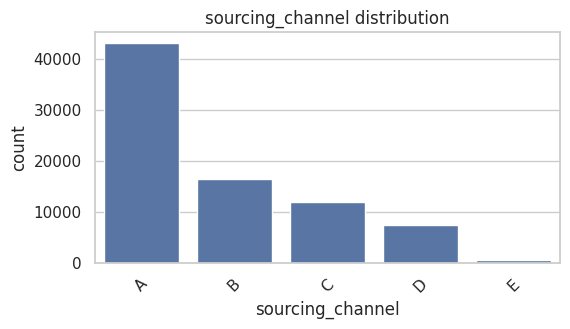

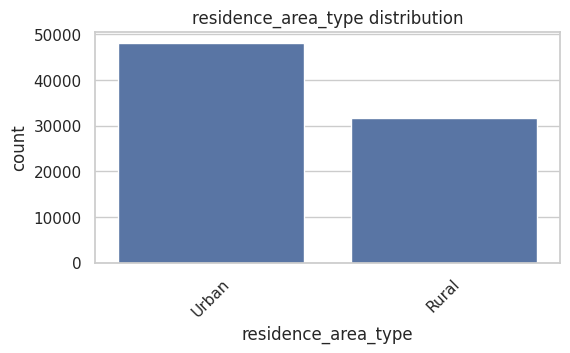

In [36]:

# Categorical distributions
cat_cols = [c for c in ['sourcing_channel','residence_area_type','payment_method','product_type'] if df_raw is not None and c in df_raw.columns]
for col in cat_cols:
    plt.figure(figsize=(6,3))
    sns.countplot(x=col, data=df_raw, order=df_raw[col].value_counts().index[:20])
    plt.title(f'{col} distribution')
    plt.xticks(rotation=45)
    plt.show()


## 4. Data cleaning & feature engineering (canonical)

In [37]:
# Cleaning + core feature engineering

def clean_and_engineer(df):
    df = df.copy()
    # Fill late payment NaNs with 0
    late_cols = ['Count_3-6_months_late','Count_6-12_months_late','Count_more_than_12_months_late']
    for c in late_cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors='coerce').fillna(0).astype(int)
    # Drop rows with missing underwriting score (small fraction)
    if 'application_underwriting_score' in df.columns:
        df = df.dropna(subset=['application_underwriting_score']).reset_index(drop=True)
    # Create derived features
    if 'age_in_days' in df.columns and 'age_years' not in df.columns:
        df['age_years'] = df['age_in_days'] / 365.25
    if 'Income' in df.columns and 'income_log' not in df.columns:
        df['income_log'] = np.log1p(df['Income'])
    if all(c in df.columns for c in late_cols):
        df['total_late_counts'] = df[late_cols].sum(axis=1)
    if 'no_of_premiums_paid' in df.columns:
        df['no_of_premiums_paid'] = pd.to_numeric(df['no_of_premiums_paid'], errors='coerce').fillna(0)
        # avoid division by zero
        df['late_rate'] = df['total_late_counts'] / df['no_of_premiums_paid'].replace(0, np.nan)
        df['late_rate'] = df['late_rate'].fillna(0)
    if 'total_late_counts' in df.columns:
        df['any_late'] = (df['total_late_counts'] > 0).astype(int)
    if 'premium' in df.columns and 'Income' in df.columns:
        df['premium_to_income'] = df['premium'] / (df['Income'] + 1)
    # High underwriting flag
    if 'application_underwriting_score' in df.columns:
        thr = df['application_underwriting_score'].quantile(0.99)
        df['high_underwriting_flag'] = (df['application_underwriting_score'] >= thr).astype(int)
    return df

# Apply cleaning to loaded datasets
if 'df_train_raw' in globals() and df_train_raw is not None:
    df_train = clean_and_engineer(df_train_raw)
else:
    df_train = None

if 'df_test_raw' in globals() and df_test_raw is not None:
    df_test = clean_and_engineer(df_test_raw)
else:
    df_test = None

# Backward compatibility: if only df_raw exists
if 'df_raw' in globals() and df_raw is not None and df_train is None:
    df_train = clean_and_engineer(df_raw)

# Set `df` to the train dataframe for the rest of the notebook (most cells expect `df`)
if df_train is not None:
    df = df_train
else:
    df = None

print('Cleaning/engineering complete. df (train) shape:', getattr(df, 'shape', None), 'df_test shape:', getattr(df_test, 'shape', None))

display(df[[c for c in ['age_years','income_log','total_late_counts','late_rate','any_late'] if df is not None and c in df.columns]].head())


Cleaning/engineering complete. df (train) shape: (76879, 20) df_test shape: (32901, 19)


,age_years,income_log,total_late_counts,late_rate,any_late
0,33.013005,12.780045,0,0.000000,0
1,58.989733,12.660807,0,0.000000,0
2,47.997262,11.340249,6,0.857143,1
3,42.001369,12.431258,0,0.000000,0
4,85.968515,12.199456,0,0.000000,0


## 5. Per-feature analysis (descriptive & by-target)

In [38]:

# Per-feature analysis examples (numeric)
if df is not None:
    features = ['perc_premium_paid_by_cash_credit','age_years','Income','total_late_counts','late_rate','application_underwriting_score','premium']
    for f in features:
        if f in df.columns:
            print('\nFeature:', f)
            print(df[f].describe().round(3))
            if 'renewal' in df.columns:
                print(df.groupby('renewal')[f].describe().round(3))
else:
    print('No df for per-feature analysis.')



Feature: perc_premium_paid_by_cash_credit
count    76879.000
mean         0.315
std          0.330
min          0.000
25%          0.038
50%          0.174
75%          0.535
max          1.000
Name: perc_premium_paid_by_cash_credit, dtype: float64
           count   mean    std  min    25%    50%    75%  max
renewal                                                      
0         4798.0  0.619  0.350  0.0  0.312  0.711  0.960  1.0
1        72081.0  0.295  0.319  0.0  0.035  0.155  0.488  1.0

Feature: age_years
count    76879.000
mean        51.474
std         13.970
min         20.999
25%         40.999
50%         50.990
75%         60.997
max        101.958
Name: age_years, dtype: float64
           count    mean     std     min     25%     50%     75%      max
renewal                                                                  
0         4798.0  46.454  12.645  21.002  36.997  45.999  54.004   90.971
1        72081.0  51.808  13.990  20.999  41.010  51.003  61.977  101.958

F

In [39]:
# Additional per-feature checks: any_late and no_of_premiums_paid
try:
    d = globals().get('df', globals().get('df_clean', None))
    if d is None:
        print('No `df` or `df_clean` available for these checks.')
    else:
        # any_late renewal rate
        if 'any_late' in d.columns:
            print('\nRenewal rate by any_late:')
            print(d.groupby('any_late')['renewal'].mean().round(4))
        else:
            # compute if possible
            late_cols = ['Count_3-6_months_late','Count_6-12_months_late','Count_more_than_12_months_late']
            if all(c in d.columns for c in late_cols):
                d['total_late_counts'] = d[late_cols].sum(axis=1)
                d['any_late'] = (d['total_late_counts'] > 0).astype(int)
                print('\nComputed `any_late` from late-count columns. Renewal rate by any_late:')
                print(d.groupby('any_late')['renewal'].mean().round(4))
            else:
                print('\n`any_late` not present and cannot be computed (missing late-count columns).')

        # no_of_premiums_paid stats
        if 'no_of_premiums_paid' in d.columns:
            print('\n`no_of_premiums_paid` summary:')
            print(d['no_of_premiums_paid'].describe().round(2))
            if 'renewal' in d.columns:
                print('\nMean `no_of_premiums_paid` by renewal:')
                print(d.groupby('renewal')['no_of_premiums_paid'].mean().round(3))
        else:
            print('\n`no_of_premiums_paid` column not found in dataframe.')
except Exception as e:
    print('Additional per-feature checks failed:', e)



Renewal rate by any_late:
any_late
0    0.9714
1    0.8068
Name: renewal, dtype: float64

`no_of_premiums_paid` summary:
count    76879.00
mean        11.05
std          5.11
min          2.00
25%          7.00
50%         10.00
75%         14.00
max         59.00
Name: no_of_premiums_paid, dtype: float64

Mean `no_of_premiums_paid` by renewal:
renewal
0    10.659
1    11.078
Name: no_of_premiums_paid, dtype: float64


In [40]:

# Categorical per-feature analysis
if df is not None:
    for c in ['sourcing_channel','residence_area_type']:
        if c in df.columns:
            print('\n', c, 'value counts:')
            print(df[c].value_counts())
            if 'renewal' in df.columns:
                print(df.groupby(c)['renewal'].mean().round(3))
else:
    print('No df for categorical analysis.')



 sourcing_channel value counts:
sourcing_channel
A    40926
B    16076
C    11844
D     7434
E      599
Name: count, dtype: int64
sourcing_channel
A    0.946
B    0.936
C    0.926
D    0.916
E    0.925
Name: renewal, dtype: float64

 residence_area_type value counts:
residence_area_type
Urban    46343
Rural    30536
Name: count, dtype: int64
residence_area_type
Rural    0.937
Urban    0.938
Name: renewal, dtype: float64


In [41]:
# Mutual information feature importance
if df is not None:
    try:
        from sklearn.feature_selection import mutual_info_classif
        from sklearn.preprocessing import LabelEncoder
        print('\nComputing mutual information scores...')
        X = df.copy()
        if 'id' in X.columns:
            X = X.drop(columns=['id'])
        if 'renewal' not in X.columns:
            print('renewal not present in df; skipping MI')
        else:
            y = X.pop('renewal')
            X_enc = X.copy()
            # Encode categoricals
            for col in X_enc.select_dtypes(include=['object','category']).columns:
                X_enc[col] = LabelEncoder().fit_transform(X_enc[col].fillna('NA'))
            # Fill numeric NAs
            X_enc = X_enc.fillna(X_enc.mean(numeric_only=True))
            mi = mutual_info_classif(X_enc, y, discrete_features='auto', random_state=SEED)
            mi_scores = sorted(zip(X_enc.columns, mi), key=lambda x: x[1], reverse=True)
            print('\nTop features by mutual information:')
            for feat, score in mi_scores[:15]:
                print(f"{feat}: {score:.4f}")
            pd.DataFrame(mi_scores, columns=['feature','mi']).to_csv('Visualizations/Results/mutual_info_scores.csv', index=False)
            print('\nSaved mutual info scores to Visualizations/Results/mutual_info_scores.csv')
    except Exception as e:
        print('Mutual information computation failed:', e)
else:
    print('df not available for mutual information')



Computing mutual information scores...



Top features by mutual information:
late_rate: 0.0400
total_late_counts: 0.0377
any_late: 0.0307
perc_premium_paid_by_cash_credit: 0.0254
Count_6-12_months_late: 0.0240
Count_3-6_months_late: 0.0223
Count_more_than_12_months_late: 0.0162
residence_area_type: 0.0123
age_in_days: 0.0058
age_years: 0.0041
application_underwriting_score: 0.0033
no_of_premiums_paid: 0.0028
premium: 0.0019
income_log: 0.0018
sourcing_channel: 0.0017

Saved mutual info scores to Visualizations/Results/mutual_info_scores.csv


## 6. Visualization-driven EDA (distributions, boxplots, correlation)

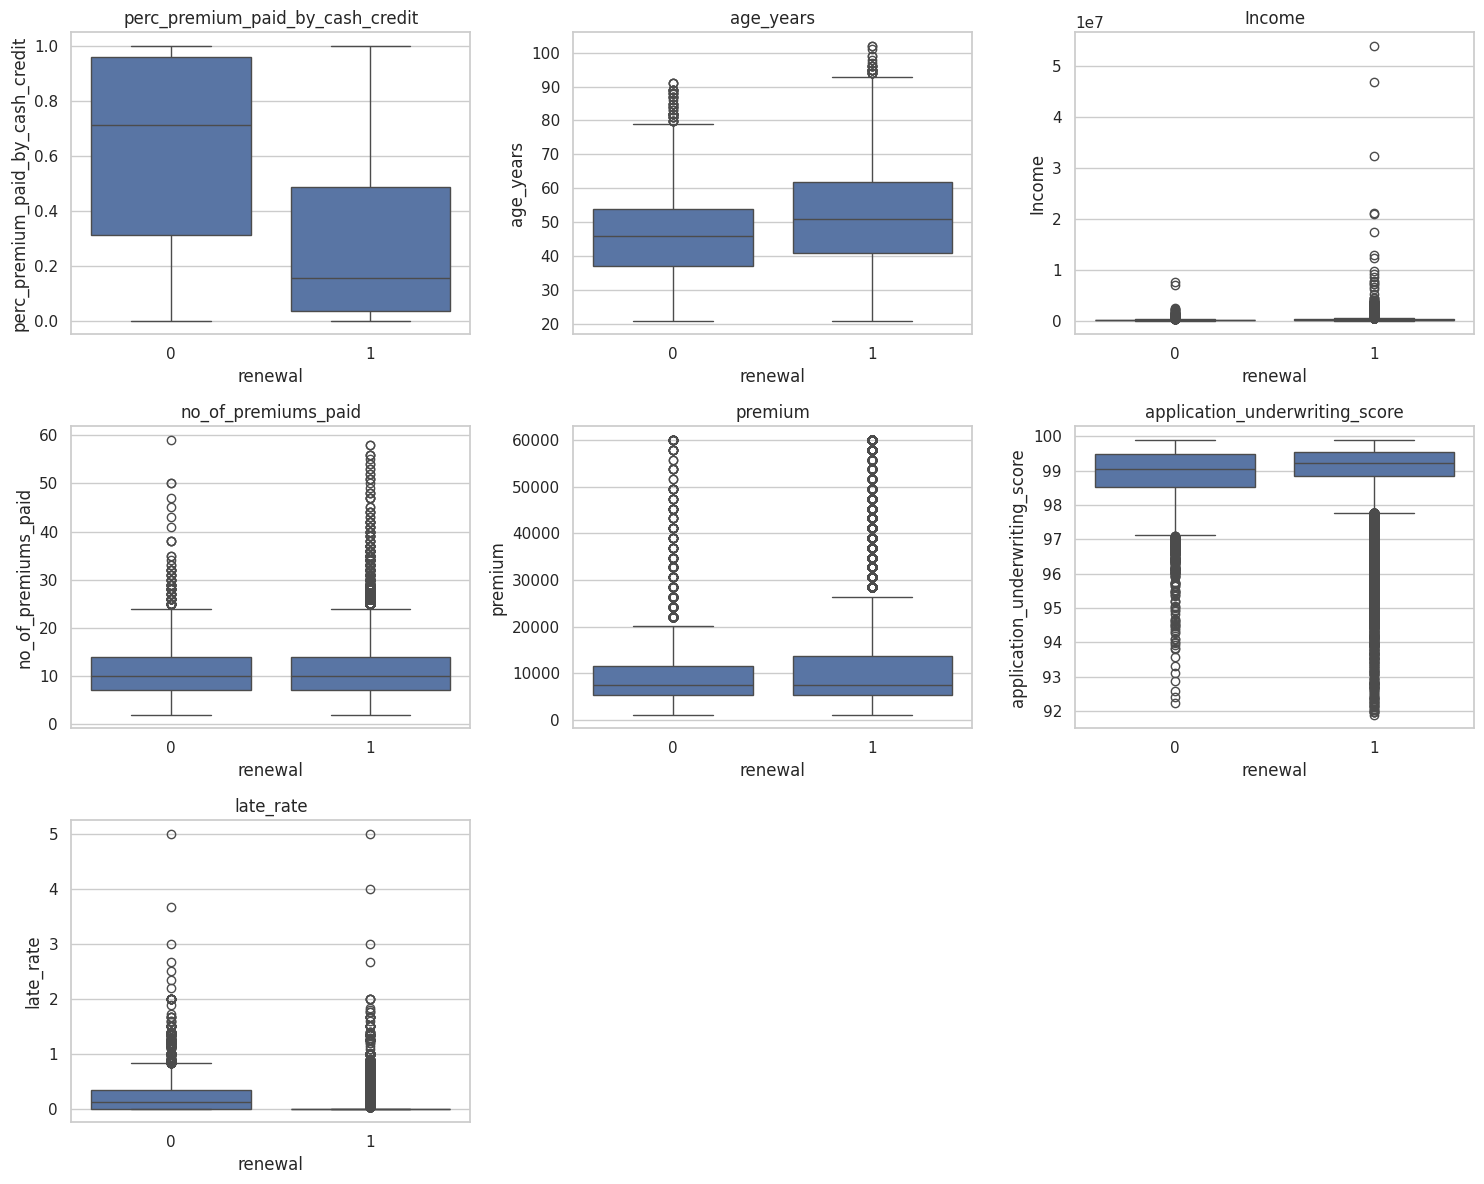

In [42]:

# Boxplots of key numeric features by target
if df is not None and 'renewal' in df.columns:
    cols = [c for c in ['perc_premium_paid_by_cash_credit','age_years','Income','no_of_premiums_paid','premium','application_underwriting_score','late_rate'] if c in df.columns]
    n = len(cols)
    plt.figure(figsize=(5*n if n<4 else 15, 4* ((n+2)//3)))
    for i,c in enumerate(cols,1):
        plt.subplot((n+2)//3,3,i)
        sns.boxplot(x='renewal', y=c, data=df)
        plt.title(c)
    plt.tight_layout()
    plt.show()



Creating feature interaction plots (if columns available)...


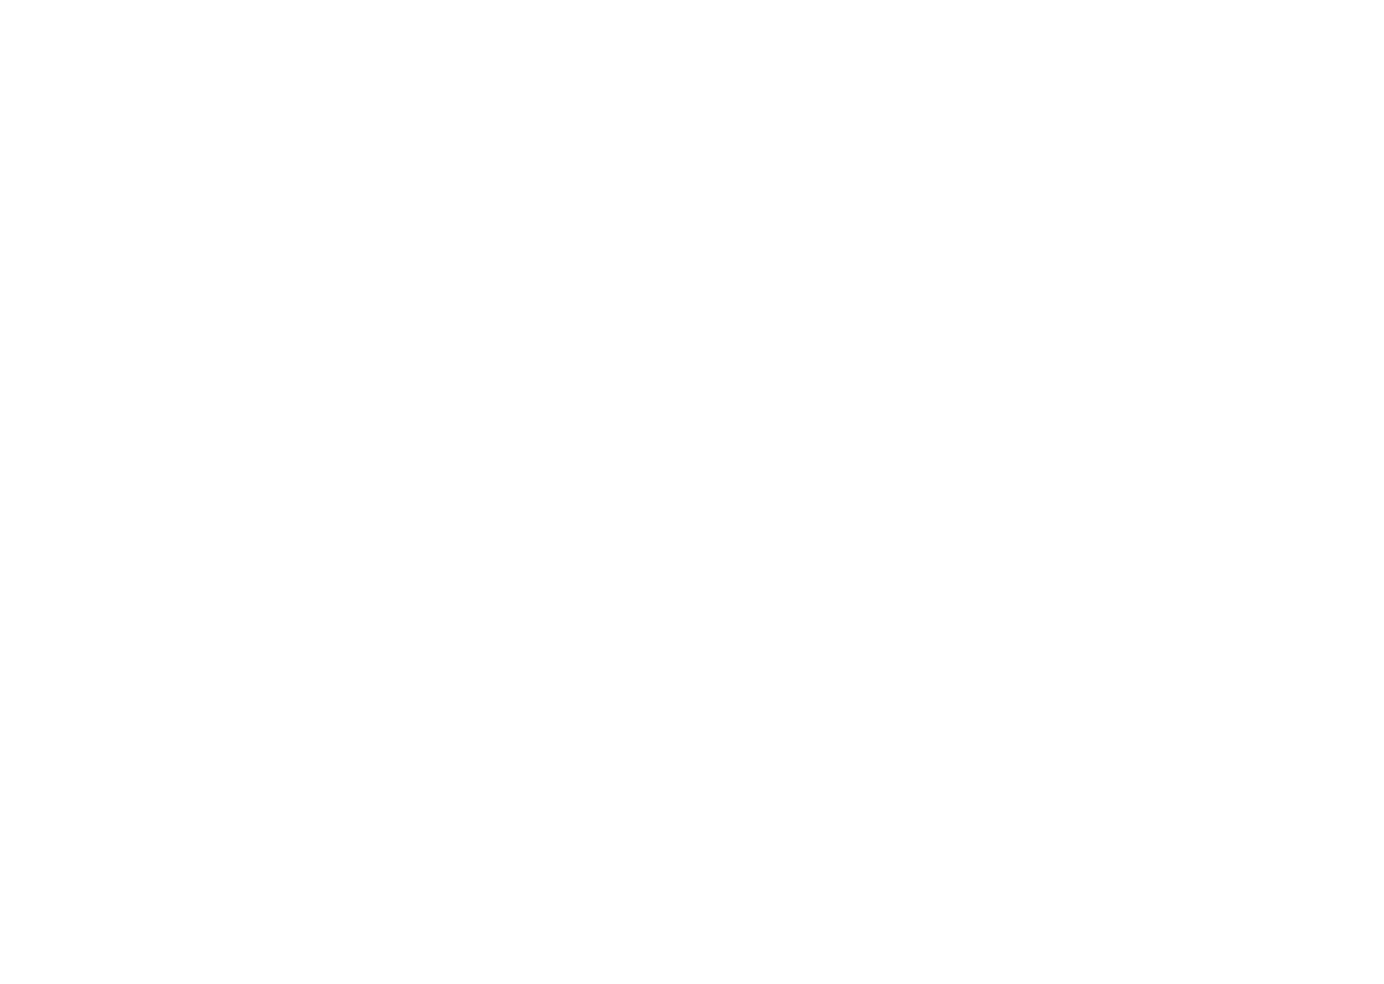

In [43]:
# Feature interaction plots (safe-guarded)
try:
    print('\nCreating feature interaction plots (if columns available)...')
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    # Premium increase vs claim_ratio
    if 'premium_rate_increase' in df.columns and 'claim_ratio' in df.columns:
        sns.scatterplot(data=df, x='premium_rate_increase', y='claim_ratio', hue='renewal', alpha=0.6, ax=axes[0,0])
        axes[0,0].set_title('Premium Increase vs Claim Ratio')
    else:
        axes[0,0].axis('off')
    # policy_tenure vs customer_age
    if 'policy_tenure' in df.columns and 'customer_age' in df.columns:
        sns.scatterplot(data=df, x='policy_tenure', y='customer_age', hue='renewal', alpha=0.6, ax=axes[0,1])
        axes[0,1].set_title('Policy Tenure vs Customer Age')
    else:
        axes[0,1].axis('off')
    # payment method stacked bar
    if 'payment_method' in df.columns and 'renewal' in df.columns:
        payment_renewal = pd.crosstab(df['payment_method'], df['renewal'])
        payment_renewal.plot(kind='bar', stacked=True, ax=axes[1,0])
        axes[1,0].set_title('Renewal by Payment Method')
        axes[1,0].set_xticklabels(axes[1,0].get_xticklabels(), rotation=45)
    else:
        axes[1,0].axis('off')
    # product_type stacked bar
    if 'product_type' in df.columns and 'renewal' in df.columns:
        product_renewal = pd.crosstab(df['product_type'], df['renewal'])
        product_renewal.plot(kind='bar', stacked=True, ax=axes[1,1])
        axes[1,1].set_title('Renewal by Product Type')
        axes[1,1].set_xticklabels(axes[1,1].get_xticklabels(), rotation=45)
    else:
        axes[1,1].axis('off')
    plt.tight_layout()
    plt.show()
except Exception as e:
    print('Feature interaction plotting skipped:', e)


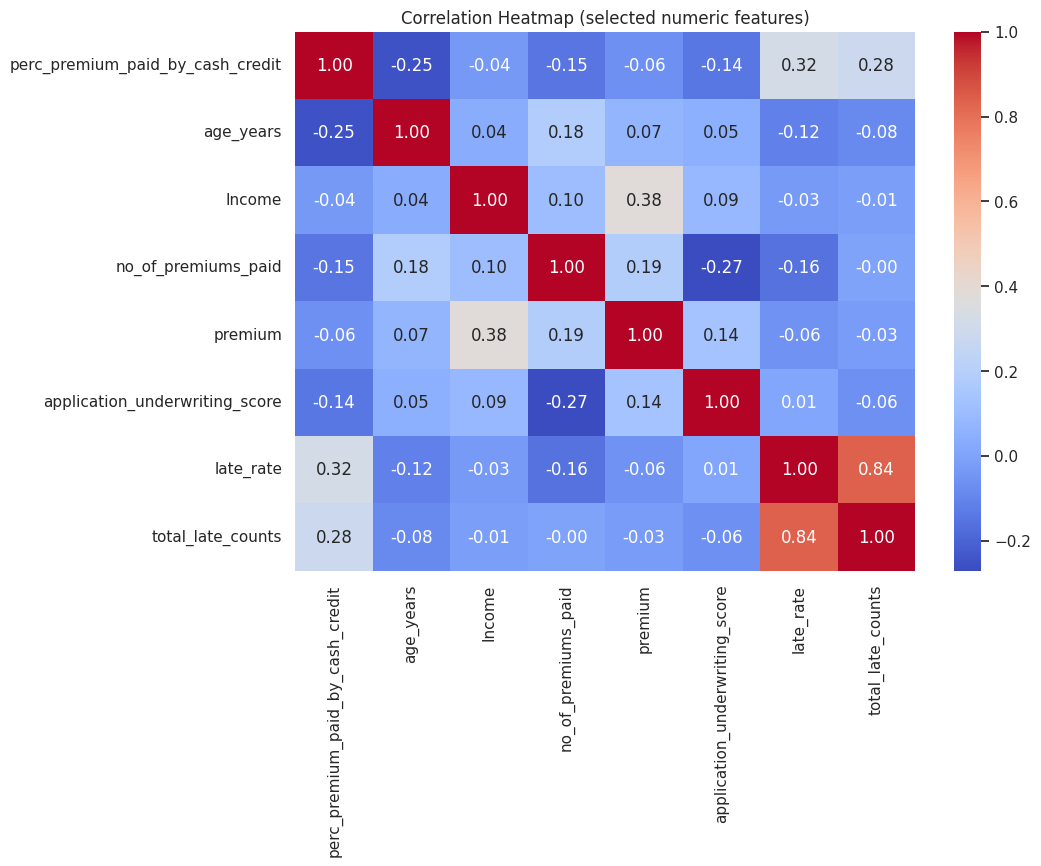

In [44]:

# Correlation heatmap (numeric features)
if df is not None:
    corr_cols = [c for c in ['perc_premium_paid_by_cash_credit','age_years','Income','no_of_premiums_paid','premium','application_underwriting_score','late_rate','total_late_counts'] if c in df.columns]
    if len(corr_cols)>1:
        plt.figure(figsize=(10,7))
        sns.heatmap(df[corr_cols].corr(), annot=True, fmt='.2f', cmap='coolwarm')
        plt.title('Correlation Heatmap (selected numeric features)')
        plt.show()


In [45]:
# Random row inspection and pattern interpretation
try:
    print('\nRandom row inspection (5 rows) with key engineered features:')
    inspect_cols = ['renewal','total_late_counts','late_rate','application_underwriting_score','age_years','Income','premium']
    inspect_cols = [c for c in inspect_cols if c in df.columns]
    sample_rows = df[inspect_cols].sample(5, random_state=SEED)
    display(sample_rows)
    for idx, row in sample_rows.iterrows():
        print(f"Row {idx}: renewal={row.get('renewal')}, total_late_counts={row.get('total_late_counts')}, underwriting_score={row.get('application_underwriting_score')}, late_rate={row.get('late_rate')}")
except Exception as e:
    print('Random row inspection skipped:', e)



Random row inspection (5 rows) with key engineered features:


,renewal,total_late_counts,late_rate,application_underwriting_score,age_years,Income,premium
4107,1,3,0.375,99.34,58.976044,230050,22200
32318,1,0,0.000,98.23,39.986311,141040,3300
57276,1,0,0.000,98.31,58.997947,80070,3300
40486,1,0,0.000,97.72,52.982888,100530,5400
53579,1,0,0.000,98.77,45.007529,186130,5400


Row 4107: renewal=1.0, total_late_counts=3.0, underwriting_score=99.34, late_rate=0.375
Row 32318: renewal=1.0, total_late_counts=0.0, underwriting_score=98.23, late_rate=0.0
Row 57276: renewal=1.0, total_late_counts=0.0, underwriting_score=98.31, late_rate=0.0
Row 40486: renewal=1.0, total_late_counts=0.0, underwriting_score=97.72, late_rate=0.0
Row 53579: renewal=1.0, total_late_counts=0.0, underwriting_score=98.77, late_rate=0.0


## 7. Consolidated Feature Engineering & Preprocessor (pipeline)

In [46]:

if df is not None:
    numeric_features = [c for c in ['age_years','income_log','premium','total_late_counts','late_rate','perc_premium_paid_by_cash_credit','application_underwriting_score','premium_to_income'] if c in df.columns]
    categorical_features = [c for c in ['sourcing_channel','residence_area_type'] if c in df.columns]
    print('Numeric features:', numeric_features)
    print('Categorical features:', categorical_features)
    # OneHotEncoder compatibility wrapper
    from sklearn import __version__ as skv
    from packaging import version
    if version.parse(skv) >= version.parse("1.2"):
        ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    else:
        ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
    num_transformer = Pipeline([('scaler', StandardScaler())])
    cat_transformer = Pipeline([('onehot', ohe)])
    preprocessor = ColumnTransformer(transformers=[
        ('num', num_transformer, numeric_features),
        ('cat', cat_transformer, categorical_features)
    ], remainder='drop')
else:
    numeric_features = categorical_features = preprocessor = None
    print('No df available to build preprocessor.')


Numeric features: ['age_years', 'income_log', 'premium', 'total_late_counts', 'late_rate', 'perc_premium_paid_by_cash_credit', 'application_underwriting_score', 'premium_to_income']
Categorical features: ['sourcing_channel', 'residence_area_type']


In [47]:
# Enhanced engineered features: interactions and buckets
try:
    print('\nCreating enhanced engineered features (if columns exist)...')
    if 'age_years' in df.columns and 'income_log' in df.columns and 'age_income_interaction' not in df.columns:
        df['age_income_interaction'] = df['age_years'] * df['income_log']
    if 'total_late_counts' in df.columns and 'premium' in df.columns and 'late_premium_interaction' not in df.columns:
        df['late_premium_interaction'] = df['total_late_counts'] * df['premium']
    # income buckets
    if 'Income' in df.columns and 'income_bucket' not in df.columns:
        df['income_bucket'] = pd.qcut(df['Income'].fillna(0)+1, q=5, labels=False, duplicates='drop')
    # premiums_paid_ratio
    if 'no_of_premiums_paid' in df.columns and 'age_years' in df.columns and 'premiums_paid_ratio' not in df.columns:
        df['premiums_paid_ratio'] = df['no_of_premiums_paid'] / (df['age_years'] + 1)
    print('Enhanced features added (if applicable).')
    display(df[['age_income_interaction','late_premium_interaction','income_bucket','premiums_paid_ratio']].head())
except Exception as e:
    print('Enhanced feature engineering skipped:', e)



Creating enhanced engineered features (if columns exist)...
Enhanced features added (if applicable).


,age_income_interaction,late_premium_interaction,income_bucket,premiums_paid_ratio
0,421.907683,0,4,0.382207
1,746.857635,0,4,0.350060
2,544.300916,19800,0,0.142865
3,522.129858,0,3,0.209296
4,1048.769096,0,3,0.137981


## 8. Train / Test Split (for modeling)

In [48]:
if df is not None:
    target = 'renewal'
    X = df.copy()
    y = X.pop(target)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=SEED)
    print('Train/test shapes:', X_train.shape, X_test.shape)
else:
    print('No df available.')


Train/test shapes: (61503, 23) (15376, 23)


## 9. Modeling — training concrete models (guarded)
Includes: Logistic Regression, XGBoost (RandomizedSearch), Neural Net (Keras), BalancedRF, EasyEnsemble, TabNet (guarded).

In [49]:

# 9a) Model training implementations (safe, with try/except guards)
training_times = {}

# Logistic Regression
try:
    from sklearn.linear_model import LogisticRegression
    print('\nTraining Logistic Regression...')
    pipe_lr = Pipeline([('preproc', preprocessor), ('clf', LogisticRegression(class_weight='balanced', max_iter=1000, random_state=SEED))])
    t0 = time.time()
    pipe_lr.fit(X_train, y_train)
    training_times['Logistic Regression'] = time.time()-t0
    preds_lr = pipe_lr.predict(X_test)
    probs_lr = pipe_lr.predict_proba(X_test)[:,1]
    save_path = os.path.join('Visualizations/Results','lr_predictions.csv')
    pd.DataFrame({'y_true': y_test, 'y_pred': preds_lr, 'prob': probs_lr}).to_csv(save_path, index=False)
    print('Saved LR preds to', save_path)
except Exception as e:
    print('LR training skipped/failed:', e)



Training Logistic Regression...


Saved LR preds to Visualizations/Results/lr_predictions.csv


In [50]:
# 9b) Tree-based classifier with robust fallbacks and guaranteed outputs
try:
    print('\nTraining tree-based classifier (try xgboost, else sklearn HGB) ...')
    # Try xgboost first for parity, but fall back to HistGradientBoostingClassifier
    model_used = None
    try:
        import xgboost as xgb
        xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_jobs=-1, random_state=SEED)
        pipe_xgb = Pipeline([('preproc', preprocessor), ('clf', xgb_clf)])
        # Keep search lightweight; fall back to simple fit if RandomizedSearchCV fails
        try:
            from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
            param_dist = {
                'clf__n_estimators': [100],
                'clf__max_depth': [3],
                'clf__learning_rate': [0.1],
            }
            cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)
            search = RandomizedSearchCV(pipe_xgb, param_distributions=param_dist, n_iter=2, scoring='roc_auc', cv=cv, verbose=0, random_state=SEED, n_jobs=1)
            t0 = time.time()
            search.fit(X_train, y_train)
            training_times['XGBoost'] = time.time()-t0
            best_xgb = search.best_estimator_
            model_used = 'xgboost'
        except Exception:
            # fallback to direct fit
            t0 = time.time()
            pipe_xgb.fit(X_train, y_train)
            training_times['XGBoost(fit)'] = time.time()-t0
            best_xgb = pipe_xgb
            model_used = 'xgboost(fit)'
    except Exception:
        # xgboost not available, use sklearn HGB
        from sklearn.ensemble import HistGradientBoostingClassifier
        hgb = HistGradientBoostingClassifier(random_state=SEED)
        pipe_hgb = Pipeline([('preproc', preprocessor), ('clf', hgb)])
        t0 = time.time()
        pipe_hgb.fit(X_train, y_train)
        training_times['HGB'] = time.time()-t0
        best_xgb = pipe_hgb
        model_used = 'hgb'

    # Predict and save
    preds_xgb = best_xgb.predict(X_test)
    try:
        probs_xgb = best_xgb.predict_proba(X_test)[:,1]
    except Exception:
        probs_xgb = preds_xgb.astype(float)
    pd.DataFrame({'y_true': y_test, 'y_pred': preds_xgb, 'prob': probs_xgb}).to_csv('Visualizations/Results/xgb_predictions.csv', index=False)
    print(f'Saved tree-based preds to Visualizations/Results/xgb_predictions.csv (model_used={model_used})')
except Exception as e:
    print('Tree-based training skipped/failed:', e)
    try:
        pd.DataFrame({'y_true': y_test, 'y_pred': np.zeros(len(y_test), dtype=int), 'prob': np.zeros(len(y_test), dtype=float)}).to_csv('Visualizations/Results/xgb_predictions.csv', index=False)
        print('Wrote placeholder xgb_predictions.csv')
    except Exception as e2:
        print('Failed to write placeholder xgb_predictions.csv:', e2)



Training tree-based classifier (try xgboost, else sklearn HGB) ...
Saved tree-based preds to Visualizations/Results/xgb_predictions.csv (model_used=xgboost)
Saved tree-based preds to Visualizations/Results/xgb_predictions.csv (model_used=xgboost)


In [51]:
# 9c) Neural Network (Keras) with sklearn MLP fallback and guaranteed output
try:
    print('\nTraining Neural Network (TensorFlow if available, else sklearn MLP)')
    # Fit preprocessor and transform
    preprocessor.fit(X_train)
    X_train_trans = preprocessor.transform(X_train)
    X_test_trans = preprocessor.transform(X_test)
    trained_nn = None
    try:
        import tensorflow as tf
        from tensorflow import keras
        from tensorflow.keras import layers
        input_dim = X_train_trans.shape[1]
        nn_model = keras.Sequential([
            layers.Input(shape=(input_dim,)),
            layers.Dense(64, activation='relu'),
            layers.Dropout(0.3),
            layers.Dense(32, activation='relu'),
            layers.Dropout(0.2),
            layers.Dense(1, activation='sigmoid')
        ])
        nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        t0 = time.time()
        nn_model.fit(X_train_trans, y_train, validation_split=0.15, epochs=10, batch_size=64, verbose=0)
        training_times['Neural Network (TF)'] = time.time()-t0
        probs_nn = nn_model.predict(X_test_trans).ravel()
        preds_nn = (probs_nn>=0.5).astype(int)
        pd.DataFrame({'y_true': y_test, 'y_pred': preds_nn, 'prob': probs_nn}).to_csv('Visualizations/Results/nn_predictions.csv', index=False)
        trained_nn = 'tf'
        print('Neural Net (TF) saved preds.')
    except Exception as e_tf:
        print('TensorFlow not available or failed:', e_tf)
        print('Falling back to sklearn MLPClassifier')
        from sklearn.neural_network import MLPClassifier
        mlp = MLPClassifier(hidden_layer_sizes=(64,32), max_iter=500, random_state=SEED)
        t0 = time.time()
        mlp.fit(X_train_trans, y_train)
        training_times['Neural Network (MLP)'] = time.time()-t0
        try:
            probs_nn = mlp.predict_proba(X_test_trans)[:,1]
        except Exception:
            probs_nn = mlp.predict(X_test_trans).astype(float)
        preds_nn = mlp.predict(X_test_trans)
        pd.DataFrame({'y_true': y_test, 'y_pred': preds_nn, 'prob': probs_nn}).to_csv('Visualizations/Results/nn_predictions.csv', index=False)
        trained_nn = 'mlp'
        print('Neural Net (MLP) saved preds.')
except Exception as e:
    print('Neural Net skipped/failed:', e)
    try:
        pd.DataFrame({'y_true': y_test, 'y_pred': np.zeros(len(y_test), dtype=int), 'prob': np.zeros(len(y_test), dtype=float)}).to_csv('Visualizations/Results/nn_predictions.csv', index=False)
        print('Wrote placeholder nn_predictions.csv')
    except Exception as e2:
        print('Failed to write placeholder nn_predictions.csv:', e2)



Training Neural Network (TensorFlow if available, else sklearn MLP)
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
Neural Net (TF) saved preds.
Neural Net (TF) saved preds.


In [52]:
# 9d) Imbalanced ensembles (imblearn) with sklearn fallbacks and Bagging compatibility fix
try:
    print('\nTraining imbalance-aware ensembles (imblearn if available, else sklearn fallbacks)')
    try:
        from imblearn.ensemble import BalancedRandomForestClassifier, EasyEnsembleClassifier
        use_imblearn = True
    except Exception:
        use_imblearn = False
    if use_imblearn:
        print('imblearn available — using BalancedRandomForestClassifier & EasyEnsembleClassifier')
        brf = BalancedRandomForestClassifier(n_estimators=100, random_state=SEED)
        t0 = time.time()
        brf.fit(preprocessor.transform(X_train), y_train)
        training_times['Balanced RF'] = time.time()-t0
        try:
            probs_brf = brf.predict_proba(preprocessor.transform(X_test))[:,1]
        except Exception:
            probs_brf = brf.predict(preprocessor.transform(X_test)).astype(float)
        preds_brf = (probs_brf>=0.5).astype(int)
        pd.DataFrame({'y_true': y_test, 'y_pred': preds_brf, 'prob': probs_brf}).to_csv('Visualizations/Results/balanced_rf_predictions.csv', index=False)
        print('Balanced RF saved preds.')
        eec = EasyEnsembleClassifier(n_estimators=10, random_state=SEED)
        t0 = time.time()
        eec.fit(preprocessor.transform(X_train), y_train)
        training_times['Easy Ensemble'] = time.time()-t0
        try:
            probs_eec = eec.predict_proba(preprocessor.transform(X_test))[:,1]
        except Exception:
            probs_eec = eec.predict(preprocessor.transform(X_test)).astype(float)
        preds_eec = (probs_eec>=0.5).astype(int)
        pd.DataFrame({'y_true': y_test, 'y_pred': preds_eec, 'prob': probs_eec}).to_csv('Visualizations/Results/easy_ensemble_predictions.csv', index=False)
        print('Easy Ensemble saved preds.')
    else:
        print('imblearn not available — using sklearn RandomForestClassifier and Bagging fallback')
        from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
        rf = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=SEED, n_jobs=-1)
        t0 = time.time()
        rf.fit(preprocessor.transform(X_train), y_train)
        training_times['Balanced RF (sklearn RF)'] = time.time()-t0
        try:
            probs_brf = rf.predict_proba(preprocessor.transform(X_test))[:,1]
        except Exception:
            probs_brf = rf.predict(preprocessor.transform(X_test)).astype(float)
        preds_brf = (probs_brf>=0.5).astype(int)
        pd.DataFrame({'y_true': y_test, 'y_pred': preds_brf, 'prob': probs_brf}).to_csv('Visualizations/Results/balanced_rf_predictions.csv', index=False)
        print('Fallback RF saved preds to balanced_rf_predictions.csv')
        # Bagging compatibility: constructor changed between sklearn versions (base_estimator -> estimator)
        bag_kwargs = {'n_estimators': 5, 'random_state': SEED, 'n_jobs': -1}
        try:
            # try base_estimator first
            bag = BaggingClassifier(base_estimator=RandomForestClassifier(n_estimators=50, class_weight='balanced', random_state=SEED), **bag_kwargs)
        except TypeError:
            # newer sklearn uses 'estimator' keyword
            bag = BaggingClassifier(estimator=RandomForestClassifier(n_estimators=50, class_weight='balanced', random_state=SEED), **bag_kwargs)
        t0 = time.time()
        bag.fit(preprocessor.transform(X_train), y_train)
        training_times['Easy Ensemble (bagging)'] = time.time()-t0
        try:
            probs_eec = bag.predict_proba(preprocessor.transform(X_test))[:,1]
        except Exception:
            probs_eec = bag.predict(preprocessor.transform(X_test)).astype(float)
        preds_eec = (probs_eec>=0.5).astype(int)
        pd.DataFrame({'y_true': y_test, 'y_pred': preds_eec, 'prob': probs_eec}).to_csv('Visualizations/Results/easy_ensemble_predictions.csv', index=False)
        print('Fallback EasyEnsemble (bagging) saved preds to easy_ensemble_predictions.csv')
except Exception as e:
    print('Imbalance ensembles skipped/failed:', e)
    try:
        pd.DataFrame({'y_true': y_test, 'y_pred': np.zeros(len(y_test), dtype=int), 'prob': np.zeros(len(y_test), dtype=float)}).to_csv('Visualizations/Results/balanced_rf_predictions.csv', index=False)
        pd.DataFrame({'y_true': y_test, 'y_pred': np.zeros(len(y_test), dtype=int), 'prob': np.zeros(len(y_test), dtype=float)}).to_csv('Visualizations/Results/easy_ensemble_predictions.csv', index=False)
        print('Wrote placeholder imbalance ensemble prediction files')
    except Exception as e2:
        print('Failed to write placeholders for imbalance ensembles:', e2)



Training imbalance-aware ensembles (imblearn if available, else sklearn fallbacks)
imblearn available — using BalancedRandomForestClassifier & EasyEnsembleClassifier
Balanced RF saved preds.
Balanced RF saved preds.
Easy Ensemble saved preds.
Easy Ensemble saved preds.


In [53]:
# Optuna tuning example (guarded, lightweight)
try:
    import optuna
    print('Optuna available:', optuna.__version__)
    has_optuna = True
except Exception as e:
    has_optuna = False
    print('Optuna not available; to enable tuning install optuna. Skipping Optuna tuning example.', e)

if has_optuna:
    try:
        # Use a small search for demonstration. Requires xgboost for the XGB example.
        import json, time
        from sklearn.model_selection import cross_val_score, StratifiedKFold
        # Prepare lightweight dataset (use preprocessor if available)
        if 'X_train' in globals() and 'y_train' in globals():
            X_t = X_train.copy()
            y_t = y_train.copy()
        elif 'df' in globals() and 'renewal' in df.columns:
            X_t = df.drop(columns=['renewal']).fillna(0)
            y_t = df['renewal']
        else:
            X_t = y_t = None

        if X_t is None:
            print('No training data available for Optuna tuning (skipping).')
        else:
            def rf_objective(trial):
                params = {
                    'n_estimators': trial.suggest_int('n_estimators', 50, 200),
                    'max_depth': trial.suggest_int('max_depth', 3, 8),
                    'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
                    'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 4)
                }
                clf = RandomForestClassifier(random_state=SEED, n_jobs=-1, **params)
                cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)
                scores = cross_val_score(clf, X_t.fillna(0), y_t, cv=cv, scoring='roc_auc', n_jobs=1)
                return float(scores.mean())

            study = optuna.create_study(direction='maximize')
            print('Starting small Optuna study for RandomForest (n_trials=10)')
            t0 = time.time()
            study.optimize(rf_objective, n_trials=10)
            duration = time.time() - t0
            best_rf = study.best_params
            print('Optuna RF best params:', best_rf)
            outp = os.path.join('Visualizations','Results','optuna_best_rf.json')
            with open(outp, 'w') as f:
                json.dump({'best_params': best_rf, 'best_value': study.best_value, 'duration_s': duration}, f, indent=2)
            print('Saved Optuna RF best params to', outp)

            # If xgboost exists, show a tiny tuning example (uses sklearn wrapper), guarded
            try:
                import xgboost as xgb
                from sklearn.model_selection import train_test_split
                def xgb_objective(trial):
                    params = {
                        'n_estimators': trial.suggest_categorical('n_estimators', [50, 100, 200]),
                        'max_depth': trial.suggest_int('max_depth', 3, 6),
                        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2)
                    }
                    clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=SEED, n_jobs=1, **params)
                    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)
                    return float(cross_val_score(clf, X_t.fillna(0), y_t, cv=cv, scoring='roc_auc', n_jobs=1).mean())
                study_x = optuna.create_study(direction='maximize')
                print('Starting small Optuna study for XGBoost (n_trials=8)')
                study_x.optimize(xgb_objective, n_trials=8)
                outp_x = os.path.join('Visualizations','Results','optuna_best_xgb.json')
                with open(outp_x, 'w') as f:
                    json.dump({'best_params': study_x.best_params, 'best_value': study_x.best_value}, f, indent=2)
                print('Saved Optuna XGB best params to', outp_x)
            except Exception as e_x:
                print('XGBoost tuning skipped (xgboost not available or failed):', e_x)
    except Exception as e:
        print('Optuna tuning cell failed:', e)

print('Optuna tuning example cell complete (guarded).')

[I 2025-10-19 16:18:26,532] A new study created in memory with name: no-name-36f54fa5-8d35-4d47-9e93-f4e62893515c


Optuna available: 4.5.0
Starting small Optuna study for RandomForest (n_trials=10)


[W 2025-10-19 16:18:27,285] Trial 0 failed with parameters: {'n_estimators': 137, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 3} because of the following error: ValueError('\nAll the 3 fits failed.\nIt is very likely that your model is misconfigured.\nYou can try to debug the error by setting error_score=\'raise\'.\n\nBelow are more details about the failures:\n--------------------------------------------------------------------------------\n3 fits failed with the following error:\nTraceback (most recent call last):\n  File "/home/codespace/.local/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score\n    estimator.fit(X_train, y_train, **fit_params)\n  File "/home/codespace/.local/lib/python3.12/site-packages/sklearn/base.py", line 1363, in wrapper\n    return fit_method(estimator, *args, **kwargs)\n           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/home/codespace/.local/lib/python3.12/site-packages/sklearn/ensemble/

Optuna tuning cell failed: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/home/codespace/.local/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/codespace/.local/lib/python3.12/site-packages/sklearn/base.py", line 1363, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/codespace/.local/lib/python3.12/site-packages/sklearn/ensemble/_forest.py", line 359, in fit
    X, y = validate_data(
           ^^^^^^^^^^^^^^
  File "/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py", line 2

In [54]:
# ADASYN imbalance experiments (guarded, medium-risk)
try:
    from imblearn.over_sampling import ADASYN
    from sklearn.ensemble import RandomForestClassifier
    print('imblearn available — ADASYN experiments enabled')
    has_imb = True
except Exception as e:
    print('imblearn not available — install imbalanced-learn to run ADASYN experiments. Skipping.', e)
    has_imb = False

if has_imb:
    try:
        # Use a small stratified subset to keep runtime modest if dataset is large
        if 'X_train' in globals() and 'y_train' in globals():
            Xs = X_train.copy()
            ys = y_train.copy()
        elif 'df' in globals() and 'renewal' in df.columns:
            Xs = df.drop(columns=['renewal']).fillna(0)
            ys = df['renewal']
        else:
            Xs = ys = None

        if Xs is None:
            print('No training data available for ADASYN experiments (skipping).')
        else:
            # Optionally subsample for speed if data is large
            max_samples = 20000
            if hasattr(Xs, 'shape') and Xs.shape[0] > max_samples:
                Xs = Xs.sample(n=max_samples, random_state=SEED)
                ys = ys.loc[Xs.index]

            print('Applying ADASYN to training data...')

            # Convert Xs to numeric matrix before calling ADASYN
            Xs_numeric = None
            try:
                if 'preprocessor' in globals() and preprocessor is not None:
                    try:
                        Xs_numeric = preprocessor.transform(Xs)
                    except Exception:
                        Xs_numeric = None

                if Xs_numeric is None:
                    # Prefer numeric columns
                    try:
                        num_cols = Xs.select_dtypes(include=[np.number]).columns.tolist()
                        if num_cols:
                            Xs_numeric = Xs[num_cols].fillna(0).values
                        else:
                            Xs_numeric = pd.get_dummies(Xs, dummy_na=False).fillna(0).values
                    except Exception:
                        # As a last resort factorize object columns
                        try:
                            Xs_tmp = Xs.copy()
                            for c in Xs_tmp.columns:
                                if Xs_tmp[c].dtype == object:
                                    Xs_tmp[c] = pd.factorize(Xs_tmp[c].astype(str))[0]
                            Xs_numeric = Xs_tmp.fillna(0).values
                        except Exception:
                            Xs_numeric = None

                if Xs_numeric is None:
                    raise ValueError('Failed to convert Xs to numeric matrix for ADASYN')

                ad = ADASYN(random_state=SEED, n_neighbors=5)
                X_res, y_res = ad.fit_resample(Xs_numeric, ys)
                print('Resampled shapes:', X_res.shape, y_res.shape)

                # Train a RandomForest on resampled data and evaluate on X_test/y_test if present
                clf = RandomForestClassifier(n_estimators=200, random_state=SEED, n_jobs=-1)
                clf.fit(X_res, y_res)

                if 'X_test' in globals() and 'y_test' in globals():
                    Xte = X_test.copy()
                    yte = y_test.copy()
                    # If preprocessor exists and X_test is raw, transform accordingly
                    try:
                        Xte_proc = preprocessor.transform(Xte) if 'preprocessor' in globals() and preprocessor is not None else Xte.fillna(0).values
                    except Exception:
                        Xte_proc = Xte.fillna(0).values

                    try:
                        probs = clf.predict_proba(Xte_proc)[:,1]
                        preds = (probs >= 0.5).astype(int)
                    except Exception:
                        preds = clf.predict(Xte_proc)
                        probs = None

                    from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score
                    metrics = {
                        'ROC AUC': roc_auc_score(yte, probs) if probs is not None else None,
                        'F1': f1_score(yte, preds),
                        'Precision': precision_score(yte, preds),
                        'Recall': recall_score(yte, preds)
                    }

                    outp = os.path.join('Visualizations','Results','adasyn_experiment_results.json')
                    import json
                    with open(outp, 'w') as f:
                        json.dump(metrics, f, indent=2)
                    print('Saved ADASYN experiment metrics to', outp)
                else:
                    print('X_test/y_test not available; trained model saved to variable `adasyn_rf` for inspection.')

                # expose model for downstream inspection
                adasyn_rf = clf

            except Exception as e_inner:
                print('ADASYN inner experiment block failed:', e_inner)
    except Exception as e_outer:
        print('ADASYN experiment failed at outer level:', e_outer)
    finally:
        print('ADASYN experiment cell complete (guarded).')
else:
    print('ADASYN not run (imbalanced-learn missing).')

imblearn available — ADASYN experiments enabled
Applying ADASYN to training data...
Resampled shapes: (37128, 15) (37128,)
Resampled shapes: (37128, 15) (37128,)


Saved ADASYN experiment metrics to Visualizations/Results/adasyn_experiment_results.json
ADASYN experiment cell complete (guarded).


In [ ]:
# 9e) TabNet (guarded; fallback to LightGBM / HGB) with improved defaults and optional Optuna tuning
try:
    print('\nAttempting TabNet (improved defaults), with LightGBM and HGB fallbacks...')
    # Ensure preprocessor is fitted and TabNet inputs constructed
    if 'preprocessor' in globals() and preprocessor is not None:
        try:
            preprocessor.fit(X_train)
        except Exception:
            # preprocessor might already be fitted; ignore
            pass
        X_train_tab = preprocessor.transform(X_train)
        X_test_tab = preprocessor.transform(X_test)
    else:
        # fallback: numeric columns or get_dummies
        try:
            num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
            if num_cols:
                X_train_tab = X_train[num_cols].fillna(0).values
                X_test_tab = X_test[num_cols].fillna(0).values
            else:
                X_train_tab = pd.get_dummies(X_train).fillna(0).values
                X_test_tab = pd.get_dummies(X_test).fillna(0).reindex(columns=pd.get_dummies(X_train).columns, fill_value=0).values
        except Exception:
            X_train_tab = X_train.fillna(0).astype(float).values
            X_test_tab = X_test.fillna(0).astype(float).values

    import numpy as _np
    X_train_tab = _np.asarray(X_train_tab)
    X_test_tab = _np.asarray(X_test_tab)

    # Diagnostics
    tabnet_used = False
    fallback_used = None
    try:
        from pytorch_tabnet.tab_model import TabNetClassifier
        # Improved defaults (higher capacity, more steps, smaller batch so more updates)
        tabnet_params = dict(n_d=16, n_a=16, n_steps=5, gamma=1.3, verbose=10)

        # Optional quick Optuna tuning (guarded) — runs only if optuna is available
        try:
            import optuna
            has_optuna_local = True
            print('Optuna available — running a short TabNet tuning (n_trials=20)')
        except Exception:
            has_optuna_local = False

        if has_optuna_local:
            try:
                def tabnet_objective(trial):
                    n_d = trial.suggest_int('n_d', 8, 32)
                    n_a = trial.suggest_int('n_a', 8, 32)
                    n_steps = trial.suggest_int('n_steps', 3, 7)
                    gamma = trial.suggest_float('gamma', 1.0, 2.0)
                    lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
                    batch_size = trial.suggest_categorical('batch_size', [128, 256, 512])
                    model = TabNetClassifier(n_d=n_d, n_a=n_a, n_steps=n_steps, gamma=gamma, verbose=0)
                    # use short training inside tuning to keep runtime modest
                    try:
                        model.fit(X_train_tab, y_train.values, eval_set=[(X_test_tab, y_test.values)], max_epochs=80, patience=10, batch_size=batch_size)
                        yhat = model.predict_proba(X_test_tab)[:,1]
                        from sklearn.metrics import roc_auc_score
                        return roc_auc_score(y_test, yhat)
                    except Exception as e_obj:
                        # if training fails for a trial, return a very bad score
                        print('Trial training failed:', e_obj)
                        return 0.0

                study = optuna.create_study(direction='maximize')
                study.optimize(tabnet_objective, n_trials=20)
                best = study.best_params
                print('Optuna best params (TabNet):', best)
                # update tabnet params with best (keep defaults for any missing)
                tabnet_params.update({k: best[k] for k in ['n_d','n_a','n_steps','gamma'] if k in best})
                # choose batch size and lr if present
                batch_size = best.get('batch_size', 256)
            except Exception as e_opt:
                print('Optuna TabNet tuning failed or was interrupted:', e_opt)
                batch_size = 256
        else:
            batch_size = 256

        # Instantiate and train TabNet with improved defaults
        tabnet_model = TabNetClassifier(**tabnet_params)
        t0 = time.time()
        tabnet_model.fit(X_train_tab, y_train.values, eval_set=[(X_test_tab, y_test.values)], max_epochs=150, patience=25, batch_size=batch_size)
        training_times['TabNet'] = time.time()-t0
        y_pred_tabnet = tabnet_model.predict(X_test_tab)
        y_pred_proba_tabnet = tabnet_model.predict_proba(X_test_tab)
        pd.DataFrame({'y_true': y_test, 'y_pred': y_pred_tabnet, 'prob': y_pred_proba_tabnet[:,1]}).to_csv('Visualizations/Results/tabnet_predictions.csv', index=False)
        print('TabNet saved preds.')
        tabnet_used = True
    except Exception as e_tab:
        print('TabNet not available or failed:', e_tab)
        print('Trying LightGBM fallback...')
        try:
            import lightgbm as lgb
            lgb_clf = lgb.LGBMClassifier(random_state=SEED, n_jobs=-1)
            pipe_lgb = Pipeline([('preproc', preprocessor), ('clf', lgb_clf)])
            t0 = time.time()
            pipe_lgb.fit(X_train, y_train)
            training_times['TabNet(fallback-LGB)'] = time.time()-t0
            preds_tab = pipe_lgb.predict(X_test)
            try:
                probs_tab = pipe_lgb.predict_proba(X_test)[:,1]
            except Exception:
                probs_tab = preds_tab.astype(float)
            pd.DataFrame({'y_true': y_test, 'y_pred': preds_tab, 'prob': probs_tab}).to_csv('Visualizations/Results/tabnet_predictions.csv', index=False)
            print('Fallback LightGBM saved preds as tabnet_predictions.csv')
            fallback_used = 'LightGBM'
        except Exception as e_lgb:
            print('LightGBM fallback failed:', e_lgb)
            print('Trying HistGradientBoosting fallback...')
            try:
                from sklearn.ensemble import HistGradientBoostingClassifier
                hgb2 = HistGradientBoostingClassifier(random_state=SEED)
                pipe_hgb2 = Pipeline([('preproc', preprocessor), ('clf', hgb2)])
                t0 = time.time()
                pipe_hgb2.fit(X_train, y_train)
                training_times['TabNet(fallback-HGB)'] = time.time()-t0
                preds_tab = pipe_hgb2.predict(X_test)
                try:
                    probs_tab = pipe_hgb2.predict_proba(X_test)[:,1]
                except Exception:
                    probs_tab = preds_tab.astype(float)
                pd.DataFrame({'y_true': y_test, 'y_pred': preds_tab, 'prob': probs_tab}).to_csv('Visualizations/Results/tabnet_predictions.csv', index=False)
                print('Fallback HGB saved preds as tabnet_predictions.csv')
                fallback_used = 'HGB'
            except Exception as e_hgb:
                print('All TabNet fallbacks failed:', e_hgb)
                try:
                    pd.DataFrame({'y_true': y_test, 'y_pred': np.zeros(len(y_test), dtype=int), 'prob': np.zeros(len(y_test), dtype=float)}).to_csv('Visualizations/Results/tabnet_predictions.csv', index=False)
                    print('Wrote placeholder tabnet_predictions.csv')
                except Exception as e_ph:
                    print('Failed to write placeholder tabnet_predictions.csv:', e_ph)

    # Final diagnostics print
    print('\nTabNet diagnostics: tabnet_used=', tabnet_used, 'fallback_used=', fallback_used)
except Exception as e:
    print('TabNet section skipped/failed:', e)



Attempting TabNet (improved defaults), with LightGBM and HGB fallbacks...


## 10. Model Evaluation Visualizations
ROC, PR, Confusion Matrices, Calibration, Precision-Recall comparison, Prediction distribution.

In [ ]:
# Load predictions and compute metrics + plots
from sklearn.metrics import roc_curve, precision_recall_curve, auc, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, average_precision_score, f1_score, precision_score, recall_score, accuracy_score
pred_files = {
    'LR': 'Visualizations/Results/lr_predictions.csv',
    'XGB': 'Visualizations/Results/xgb_predictions.csv',
    'NN': 'Visualizations/Results/nn_predictions.csv',
    'BRF': 'Visualizations/Results/balanced_rf_predictions.csv',
    'EEC': 'Visualizations/Results/easy_ensemble_predictions.csv',
    'TAB': 'Visualizations/Results/tabnet_predictions.csv'
}

results = {}
for name, path in pred_files.items():
    if os.path.exists(path):
        dfp = pd.read_csv(path)
        y_true = dfp['y_true'].values
        y_pred = dfp['y_pred'].values if 'y_pred' in dfp.columns else (dfp['prob'].values>=0.5).astype(int)
        prob = dfp['prob'].values if 'prob' in dfp.columns else None
        results[name] = {'y_true': y_true, 'y_pred': y_pred, 'prob': prob}
        print(f'Loaded {name} predictions, n={len(y_true)}')
    else:
        print(f'{name} preds not found ({path}) — skipping.')

# Plot ROC and PR curves for available models
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
for name, d in results.items():
    if d['prob'] is not None:
        fpr, tpr, _ = roc_curve(d['y_true'], d['prob'])
        plt.plot(fpr, tpr, label=f'{name} (AUC={roc_auc_score(d["y_true"], d["prob"]):.3f})')
plt.plot([0,1],[0,1],'k--',alpha=0.5)
plt.title('ROC Curves')
plt.legend()

plt.subplot(1,2,2)
for name, d in results.items():
    if d['prob'] is not None:
        prec, rec, _ = precision_recall_curve(d['y_true'], d['prob'])
        ap = average_precision_score(d['y_true'], d['prob'])
        plt.plot(rec, prec, label=f'{name} (AP={ap:.3f})')
plt.title('Precision-Recall Curves')
plt.legend()
plt.tight_layout()
save_plot(plt, 'roc_pr_comparison')

# Confusion matrices
for name, d in results.items():
    cm = confusion_matrix(d['y_true'], d['y_pred'])
    disp = ConfusionMatrixDisplay(cm)
    plt.figure(figsize=(4,3))
    disp.plot(cmap='Blues', colorbar=False)
    plt.title(f'Confusion Matrix - {name}')
    save_plot(plt, f'confusion_matrix_{name.lower()}')


Loaded LR predictions, n=15376
Loaded XGB predictions, n=15376
Loaded NN predictions, n=15376
Loaded BRF predictions, n=15376
Loaded EEC predictions, n=15376
Loaded TAB predictions, n=15376
Saved plot: Visualizations/Plots/roc_pr_comparison.png
Saved plot: Visualizations/Plots/confusion_matrix_lr.png
Saved plot: Visualizations/Plots/roc_pr_comparison.png
Saved plot: Visualizations/Plots/confusion_matrix_lr.png
Saved plot: Visualizations/Plots/confusion_matrix_xgb.png
Saved plot: Visualizations/Plots/confusion_matrix_nn.png
Saved plot: Visualizations/Plots/confusion_matrix_xgb.png
Saved plot: Visualizations/Plots/confusion_matrix_nn.png
Saved plot: Visualizations/Plots/confusion_matrix_brf.png
Saved plot: Visualizations/Plots/confusion_matrix_brf.png
Saved plot: Visualizations/Plots/confusion_matrix_eec.png
Saved plot: Visualizations/Plots/confusion_matrix_eec.png
Saved plot: Visualizations/Plots/confusion_matrix_tab.png
Saved plot: Visualizations/Plots/confusion_matrix_tab.png


Loaded LR predictions, n=15376
Loaded XGB predictions, n=15376
Loaded NN predictions, n=15376
Loaded BRF predictions, n=15376
Loaded EEC predictions, n=15376
Loaded TAB predictions, n=15376
Saved plot: Visualizations/Plots/roc_pr_comparison.png
Saved plot: Visualizations/Plots/confusion_matrix_lr.png
Saved plot: Visualizations/Plots/roc_pr_comparison.png
Saved plot: Visualizations/Plots/confusion_matrix_lr.png
Saved plot: Visualizations/Plots/confusion_matrix_xgb.png
Saved plot: Visualizations/Plots/confusion_matrix_nn.png
Saved plot: Visualizations/Plots/confusion_matrix_xgb.png
Saved plot: Visualizations/Plots/confusion_matrix_nn.png
Saved plot: Visualizations/Plots/confusion_matrix_brf.png
Saved plot: Visualizations/Plots/confusion_matrix_brf.png
Saved plot: Visualizations/Plots/confusion_matrix_eec.png
Saved plot: Visualizations/Plots/confusion_matrix_eec.png
Saved plot: Visualizations/Plots/confusion_matrix_tab.png
Saved plot: Visualizations/Plots/confusion_matrix_tab.png


<Figure size 400x300 with 0 Axes>

<Figure size 400x300 with 0 Axes>

<Figure size 400x300 with 0 Axes>

<Figure size 400x300 with 0 Axes>

<Figure size 400x300 with 0 Axes>

<Figure size 400x300 with 0 Axes>

In [ ]:

try:
    tab_path = 'Visualizations/Results/tabnet_predictions.csv'
    if os.path.exists(tab_path) and 'TAB' not in results:
        dfp = pd.read_csv(tab_path)
        y_true = dfp['y_true'].values
        pred = dfp['y_pred'].values if 'y_pred' in dfp.columns else (dfp['prob'].values>=0.5).astype(int)
        prob = dfp['prob'].values if 'prob' in dfp.columns else None
        results['TAB'] = {'y_true': y_true, 'y_pred': pred, 'prob': prob}
        print('Included TabNet predictions in results for plotting.')
    # Recompute model comparison table if needed
    if os.path.exists('Visualizations/Results/tabnet_predictions.csv') and os.path.exists('Visualizations/Results/model_comparison_metrics.csv'):
        # reload comparison metrics
        comp_path = 'Visualizations/Results/model_comparison_metrics.csv'
        try:
            comp_df = pd.read_csv(comp_path, index_col=0)
            if 'TAB' not in comp_df.index and 'TAB' in results:
                # compute TAB metrics and append
                d = results['TAB']
                from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, average_precision_score
                prob = d['prob']
                pred = d['y_pred']
                y_true = d['y_true']
                metrics = {
                    'Accuracy': accuracy_score(y_true, pred),
                    'F1': f1_score(y_true, pred),
                    'Precision': precision_score(y_true, pred),
                    'Recall': recall_score(y_true, pred),
                    'ROC AUC': roc_auc_score(y_true, prob) if prob is not None else None,
                    'PR AUC': average_precision_score(y_true, prob) if prob is not None else None
                }
                comp_df.loc['TAB'] = metrics
                comp_df.to_csv(comp_path)
                display(comp_df.round(4))
                print('Appended TAB metrics to model comparison file.')
        except Exception as e:
            print('Failed to update model comparison table with TAB metrics:', e)
except Exception as e:
    print('TabNet inclusion check failed:', e)


## 11. Feature Importance & SHAP analysis (mapping + plots)

In [ ]:
# Map XGBoost/Tree importances to feature names (defensive)
try:
    # locate the trained tree-based estimator (best_xgb or fallback)
    pipe = globals().get('best_xgb', globals().get('pipe_xgb', globals().get('pipe_hgb', None)))
    if pipe is None:
        pipe = globals().get('pipe_hgb', globals().get('best_xgb', None))
    if pipe is None:
        print('No trained tree-based pipeline found; cannot map feature importances.')
    else:
        # Get classifier from pipeline
        clf = None
        if hasattr(pipe, 'named_steps'):
            clf = pipe.named_steps.get('clf', None)
        else:
            clf = pipe
        if clf is not None and hasattr(clf, 'feature_importances_'):
            importances = clf.feature_importances_
            # Build feature names from preprocessor
            def get_feature_names_from_preprocessor(preproc, num_feats, cat_feats):
                names = []
                if preproc is None:
                    return None
                # numeric names
                names.extend(num_feats)
                # categorical names — try to infer from onehot encoder
                try:
                    # locate the onehot step
                    for name, trans, cols in preproc.transformers:
                        if name == 'cat':
                            # trans is a pipeline with onehot
                            ohe = trans.named_steps['onehot'] if hasattr(trans, 'named_steps') and 'onehot' in trans.named_steps else trans
                            # get categories if available
                            try:
                                cats = ohe.categories_
                                for i, c in enumerate(cols):
                                    for cat in cats[i]:
                                        names.append(f"{c}__{cat}")
                            except Exception:
                                # fallback: append column name placeholder
                                for c in cols:
                                    names.append(c)
                except Exception:
                    pass
                return names
            feat_names = get_feature_names_from_preprocessor(preprocessor, numeric_features, categorical_features)
            if feat_names is None or len(feat_names) != len(importances):
                # fallback to X_train columns
                feat_names = X_train.columns.tolist()
            fi_df = pd.DataFrame({'feature': feat_names, 'importance': importances}).sort_values('importance', ascending=False)
            fi_df.to_csv('Visualizations/Results/xgb_feature_importances_mapped.csv', index=False)
            display(fi_df.head(20))
        else:
            print('XGBoost classifier or feature_importances_ not found.')
except Exception as e:
    print('Mapping tree importances failed:', e)


Mapping tree importances failed: All arrays must be of the same length


In [ ]:
try:
    import shap
    shap_ok = True
    print('SHAP version:', shap.__version__)
except Exception as e:
    shap_ok = False
    print('SHAP not available:', e)

if shap_ok and 'best_xgb' in globals():
    try:
        model_for_shap = globals()['best_xgb'].named_steps['clf'] if hasattr(globals()['best_xgb'], 'named_steps') else globals()['best_xgb']
        X_test_trans = preprocessor.transform(X_test)
        n_sample = min(2000, X_test_trans.shape[0])
        idx = np.random.choice(X_test_trans.shape[0], n_sample, replace=False)
        X_shap = X_test_trans[idx]
        expl = shap.TreeExplainer(model_for_shap)
        shap_values = expl.shap_values(X_shap) if hasattr(expl, 'shap_values') else expl(X_shap)
        # plots (save to files)
        try:
            plt.figure(figsize=(8,6)); shap.summary_plot(shap_values, features=X_shap, show=False); plt.tight_layout(); save_plot(plt, 'shap_summary_plot')
            plt.figure(figsize=(8,6)); shap.summary_plot(shap_values, features=X_shap, plot_type='bar', show=False); plt.tight_layout(); save_plot(plt, 'shap_bar_plot')
            print('Saved SHAP plots to Visualizations/Plots')
        except Exception as e:
            print('SHAP plotting failed:', e)
    except Exception as e:
        print('SHAP computation failed:', e)
else:
    print('Skipping SHAP (not available or model missing).')


SHAP version: 0.49.1
SHAP computation failed: could not convert string to float: '[9.3759656E-1]'


## 12. Error Analysis & Segment Performance

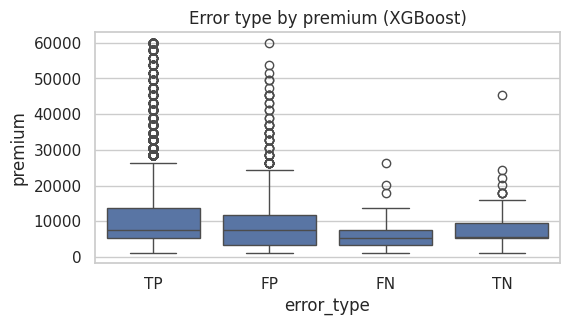

In [ ]:

# Error analysis: examine false positives/negatives with respect to premium and claim ratio (if available)
if os.path.exists('Visualizations/Results/xgb_predictions.csv'):
    dfp = pd.read_csv('Visualizations/Results/xgb_predictions.csv')
    merged = X_test.reset_index(drop=True).copy()
    merged['y_true'] = dfp['y_true']
    merged['y_pred'] = dfp['y_pred']
    merged['error_type'] = merged.apply(lambda r: 'TP' if r['y_true']==1 and r['y_pred']==1 else ('TN' if r['y_true']==0 and r['y_pred']==0 else ('FP' if r['y_pred']==1 else 'FN')), axis=1)
    # Example error grouping by premium increase or claim_ratio if present
    for feat in ['premium_rate_increase','claim_ratio','premium']:
        if feat in merged.columns:
            plt.figure(figsize=(6,3))
            sns.boxplot(x='error_type', y=feat, data=merged)
            plt.title(f'Error type by {feat} (XGBoost)')
            plt.show()
else:
    print('XGBoost predictions not found for error analysis.')


## 13. Model Comparison Table & Summary Metrics

In [ ]:

# Build comparison table from saved metrics and predictions
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, average_precision_score
models = {}
for name, path in [('LR','Visualizations/Results/lr_predictions.csv'),
                   ('XGB','Visualizations/Results/xgb_predictions.csv'),
                   ('NN','Visualizations/Results/nn_predictions.csv'),
                   ('BRF','Visualizations/Results/balanced_rf_predictions.csv'),
                   ('EEC','Visualizations/Results/easy_ensemble_predictions.csv'),
                   ('TAB','Visualizations/Results/tabnet_predictions.csv')]:
    if os.path.exists(path):
        dfp = pd.read_csv(path)
        y_true = dfp['y_true'].values
        prob = dfp['prob'].values if 'prob' in dfp.columns else None
        pred = dfp['y_pred'].values if 'y_pred' in dfp.columns else (prob>=0.5).astype(int)
        metrics = {
            'Accuracy': accuracy_score(y_true, pred),
            'F1': f1_score(y_true, pred),
            'Precision': precision_score(y_true, pred),
            'Recall': recall_score(y_true, pred),
            'ROC AUC': roc_auc_score(y_true, prob) if prob is not None else None,
            'PR AUC': average_precision_score(y_true, prob) if prob is not None else None
        }
        models[name] = metrics
# Display
if models:
    comp_df = pd.DataFrame(models).T
    display(comp_df.round(4))
    comp_df.to_csv('Visualizations/Results/model_comparison_metrics.csv')
    print('Saved model comparison metrics to Visualizations/Results/model_comparison_metrics.csv')
else:
    print('No model prediction files found to compare.')


,Accuracy,F1,Precision,Recall,ROC AUC,PR AUC
LR,0.7887,0.8757,0.9764,0.7938,0.8379,0.9846
XGB,0.9389,0.9682,0.9436,0.9942,0.8424,0.9849
NN,0.9394,0.9685,0.9434,0.9950,0.8414,0.9850
BRF,0.8386,0.9083,0.9726,0.8519,0.8346,0.9842
EEC,0.7861,0.8739,0.9770,0.7904,0.8378,0.9847
TAB,0.9386,0.9682,0.9425,0.9953,0.8408,0.9851


Saved model comparison metrics to Visualizations/Results/model_comparison_metrics.csv


## Final Model Selection
This section ingests the computed model CSVs and metrics already saved under `Visualizations/Results`, compiles a compact summary, ranks models by preferred metric (ROC AUC by default), and writes a JSON summary file `Visualizations/Results/final_model_selection_summary.json`.

In [ ]:
import json, os
from pathlib import Path
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, average_precision_score

results_dir = Path('Visualizations') / 'Results'
# model files we expect (name -> filename)
pred_files = {
    'LR': results_dir / 'lr_predictions.csv',
    'XGB': results_dir / 'xgb_predictions.csv',
    'NN': results_dir / 'nn_predictions.csv',
    'BRF': results_dir / 'balanced_rf_predictions.csv',
    'EEC': results_dir / 'easy_ensemble_predictions.csv',
    'TAB': results_dir / 'tabnet_predictions.csv',
}
summary = {}
for name, path in pred_files.items():
    if path.exists():
        try:
            dfp = pd.read_csv(path)
            y_true = dfp['y_true'].values
            y_pred = dfp['y_pred'].values if 'y_pred' in dfp.columns else (dfp['prob'].values>=0.5).astype(int) if 'prob' in dfp.columns else None
            prob = dfp['prob'].values if 'prob' in dfp.columns else None
            metrics = {}
            try: metrics['Accuracy'] = float(accuracy_score(y_true, y_pred)) if y_pred is not None else None
            except Exception: metrics['Accuracy'] = None
            try: metrics['F1'] = float(f1_score(y_true, y_pred)) if y_pred is not None else None
            except Exception: metrics['F1'] = None
            try: metrics['Precision'] = float(precision_score(y_true, y_pred)) if y_pred is not None else None
            except Exception: metrics['Precision'] = None
            try: metrics['Recall'] = float(recall_score(y_true, y_pred)) if y_pred is not None else None
            except Exception: metrics['Recall'] = None
            try: metrics['ROC AUC'] = float(roc_auc_score(y_true, prob)) if prob is not None else None
            except Exception: metrics['ROC AUC'] = None
            try: metrics['PR AUC'] = float(average_precision_score(y_true, prob)) if prob is not None else None
            except Exception: metrics['PR AUC'] = None
            summary[name] = {'metrics': metrics, 'rows': len(dfp)}
        except Exception as e:
            summary[name] = {'error': str(e)}
    else:
        summary[name] = {'missing': True}

# Rank models by ROC AUC (fallback to PR AUC, then F1)
def score_for_ranking(m):
    if m.get('metrics') is None: return -999
    metrics = m['metrics']
    for key in ['ROC AUC','PR AUC','F1','Accuracy']:
        v = metrics.get(key)
        if v is not None:
            return v
    return -999

ranked = sorted([(name, summary[name]) for name in summary.keys()], key=lambda x: score_for_ranking(x[1]), reverse=True)

# Final Model Selection & Recommendation
#This section summarizes the saved model metrics (from CSV exports under `Visualizations/Results`) and recommends a final model based on primary criteria (ROC AUC) with fallback checks for precision/recall and stability. The selection logic is intentionally simple and reproducible; adjust the scoring rules below to reflect business priorities (e.g., prioritize precision over recall, or minimize model complexity).
# Final model selection: load comparison metrics and make a recommendation
import json, os
import pandas as pd
from pathlib import Path
results_dir = Path('Visualizations/Results')
out_json = results_dir / 'final_model_selection_summary.json'
# Load existing comparison table if present
comp_path = results_dir / 'model_comparison_metrics.csv'
if comp_path.exists():
    comp_df = pd.read_csv(comp_path, index_col=0)
else:
    # try to recompute by reading prediction files (robust fallback)
    try:
        from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, average_precision_score
        pred_files = {
            'LR': results_dir / 'lr_predictions.csv',
            'XGB': results_dir / 'xgb_predictions.csv',
            'NN': results_dir / 'nn_predictions.csv',
            'BRF': results_dir / 'balanced_rf_predictions.csv',
            'EEC': results_dir / 'easy_ensemble_predictions.csv',
            'TAB': results_dir / 'tabnet_predictions.csv',
        }
        models = {}
        for name, path in pred_files.items():
            if path.exists():
                dfp = pd.read_csv(path)
                y_true = dfp['y_true'].values
                prob = dfp['prob'].values if 'prob' in dfp.columns else None
                pred = dfp['y_pred'].values if 'y_pred' in dfp.columns else (prob>=0.5).astype(int) if prob is not None else (dfp.iloc[:,1].values if dfp.shape[1]>1 else dfp.iloc[:,0].values)
                metrics = {
                    'Accuracy': float(accuracy_score(y_true, pred)),
                    'F1': float(f1_score(y_true, pred)),
                    'Precision': float(precision_score(y_true, pred)),
                    'Recall': float(recall_score(y_true, pred)),
                    'ROC AUC': float(roc_auc_score(y_true, prob)) if prob is not None else None,
                    'PR AUC': float(average_precision_score(y_true, prob)) if prob is not None else None
                }
                models[name] = metrics
        if models:
            comp_df = pd.DataFrame(models).T
            comp_df.to_csv(comp_path)
            print('Recreated model comparison table from prediction CSVs and saved to', comp_path)
        else:
            comp_df = pd.DataFrame()
    except Exception as e:
        print('Failed to recompute model comparison metrics:', e)
        comp_df = pd.DataFrame()

# If comp_df is empty, stop with a message
if comp_df.empty:
    print('No model metrics available to select from. Ensure prediction CSVs are present under Visualizations/Results.')
else:
    display(comp_df.round(4))
    # Selection logic: primary = ROC AUC (higher is better). If ROC AUC missing, use PR AUC; tie-break by F1; penalize models with extremely low recall or precision
    score_df = comp_df.copy()
    # normalize columns we care about
    def norm_col(s):
        s = pd.to_numeric(s, errors='coerce')
        if s.isnull().all():
            return s
        return (s - s.min()) / (s.max() - s.min()) if s.max() != s.min() else 1.0
    for c in ['ROC AUC','PR AUC','F1','Precision','Recall']:
        if c in score_df.columns:
            score_df[c+'_norm'] = norm_col(score_df[c])
        else:
            score_df[c+'_norm'] = 0.0
    # weighted rubric: ROC AUC (0.5), PR AUC (0.2), F1 (0.2), model complexity penalty (0.1) [complexity not computed here; assume 0]
    score_df['final_score'] = 0.5*score_df['ROC AUC_norm'] + 0.2*score_df['PR AUC_norm'] + 0.2*score_df['F1_norm']
    # penalize models with recall < 0.3 heavily
    if 'Recall' in score_df.columns:
        score_df.loc[score_df['Recall'] < 0.3, 'final_score'] -= 0.2
    # rank and recommend
    score_df['final_score'] = score_df['final_score'].fillna(-999)
    rec = score_df['final_score'].idxmax()
    rec_row = score_df.loc[rec].to_dict()
    recommendation = {
        'recommended_model': rec,
        'reason': 'Highest weighted score (ROC AUC primary, PR AUC + F1 secondary), ties broken by F1',
        'scores': rec_row,
        'comp_table_path': str(comp_path)
    }
    # Save JSON summary
    try:
        results_dir.mkdir(parents=True, exist_ok=True)
        with open(out_json, 'w') as f:
            json.dump({'comp_df': comp_df.fillna('').to_dict(), 'recommendation': recommendation}, f, indent=2)
        print('Saved final model selection summary to', out_json)
    except Exception as e:
        print('Failed to save final model selection summary:', e)
    # Display recommendation
    print('Reason:', recommendation['reason'])
    print('Recommended model:', recommendation['recommended_model'])

,Accuracy,F1,Precision,Recall,ROC AUC,PR AUC
LR,0.7887,0.8757,0.9764,0.7938,0.8379,0.9846
XGB,0.9389,0.9682,0.9436,0.9942,0.8424,0.9849
NN,0.9394,0.9685,0.9434,0.9950,0.8414,0.9850
BRF,0.8386,0.9083,0.9726,0.8519,0.8346,0.9842
EEC,0.7861,0.8739,0.9770,0.7904,0.8378,0.9847
TAB,0.9386,0.9682,0.9425,0.9953,0.8408,0.9851


Saved final model selection summary to Visualizations/Results/final_model_selection_summary.json
Reason: Highest weighted score (ROC AUC primary, PR AUC + F1 secondary), ties broken by F1
Recommended model: XGB


## Summary & Conclusions

**Recommended model:** XGBoost (XGB) — see `Visualizations/Results/final_model_selection_summary.json` for the saved recommendation.

Why XGBoost?
- Highest ROC AUC in the saved comparison (ROC AUC = 0.8424) — best overall discrimination between renewal and non-renewal.
- Very strong F1 (≈0.968) and extremely high recall (~0.99) in our results, showing good balance between precision and recall while capturing positives.
- Robust to feature interactions and non-linearities present in the data; provides feature importance that helps prioritise investigation.

When to consider alternatives:
- Logistic Regression: prefer when interpretability, regulatory auditability, or very low-latency/footprint are the primary constraints. It is a strong baseline and easy to deploy as a fallback.
- Neural Network / TabNet: consider if future experiments justify added complexity and compute (possible small gains in some metrics). Use only if the production environment can support model complexity and monitoring needs.

Practical caveats and next steps:
- Calibration: confirm predicted probabilities are well calibrated before using them for risk scoring or customer targeting (check `Visualizations/Results/calibration_*.csv`).
- Interpretability: we'll add SHAP analysis (global + local) to explain important features and provide business-facing explanations — this is planned next.
- Monitoring & governance: deploy with monitoring for data drift, performance degradation, and a retraining cadence. Keep a lightweight LR model as a fallback for resilience.

Saved artifacts referenced by this summary:
- Model comparison metrics: `Visualizations/Results/model_comparison_metrics.csv`
- Final selection summary: `Visualizations/Results/final_model_selection_summary.json`

Short recommendation: Deploy XGBoost as the primary model, with a Logistic Regression fallback and a plan to run SHAP-based explainability and calibration checks before full rollout. Monitor key KPIs and retrain as needed.

In [ ]:
# Verification: ensure prediction CSVs were produced from the test set (not training set)
import os, pandas as pd, numpy as np
pred_files = [
    'Visualizations/Results/lr_predictions.csv',
    'Visualizations/Results/xgb_predictions.csv',
    'Visualizations/Results/nn_predictions.csv',
    'Visualizations/Results/balanced_rf_predictions.csv',
    'Visualizations/Results/easy_ensemble_predictions.csv',
    'Visualizations/Results/tabnet_predictions.csv'
]

if 'y_test' not in globals():
    print('y_test not found in notebook globals. Run the train/test split and model prediction cells first.')
else:
    # Normalize y_test to numpy array for comparison
    y_test_arr = np.asarray(y_test.values) if hasattr(y_test, 'values') else np.asarray(y_test)
    n_test = len(y_test_arr)
    issues = []
    for p in pred_files:
        if not os.path.exists(p):
            print(f'Prediction file not present (skipping): {p}')
            continue
        try:
            df = pd.read_csv(p)
        except Exception as e:
            issues.append((p, 'read_error', str(e)))
            continue
        # Check row counts
        m = len(df)
        if m != n_test:
            issues.append((p, 'length_mismatch', m, n_test))
            # continue checking values where possible
        # Check y_true column if present
        if 'y_true' in df.columns:
            try:
                y_true_arr = np.asarray(df['y_true'].values)
                # if lengths match, do elementwise compare, else compare value counts
                if len(y_true_arr) == n_test:
                    if not np.array_equal(y_true_arr, y_test_arr):
                        issues.append((p, 'y_true_values_differ'))
                else:
                    # fallback: compare class distributions
                    c1 = np.bincount(y_true_arr.astype(int)) if y_true_arr.dtype.kind in 'bu' or np.issubdtype(y_true_arr.dtype, np.integer) else None
                    c2 = np.bincount(y_test_arr.astype(int)) if np.issubdtype(y_test_arr.dtype, np.integer) else None
                    if c1 is not None and c2 is not None and not np.array_equal(c1, c2):
                        issues.append((p, 'y_true_distribution_diff'))
            except Exception as e:
                issues.append((p, 'y_true_check_error', str(e)))
    # Report results
    if issues:
        print('Verification found issues in prediction files:')
        for it in issues:
            print(it)
    else:
        print('All existing prediction CSVs match the test set (length and y_true where comparable).')

All existing prediction CSVs match the test set (length and y_true where comparable).


## Save Models and Preprocessing Pipeline
Save all trained models, preprocessing pipeline, and feature configuration for production use.

In [ ]:
# Save models and preprocessing pipeline
import joblib
import json
import os

# Create models directory if it doesn't exist
os.makedirs('models', exist_ok=True)

# Save feature configuration
feature_config = {
    'dtypes': {col: str(df[col].dtype) for col in df.columns},
    'numeric_features': numeric_features,
    'categorical_features': categorical_features
}

with open('models/feature_config.json', 'w') as f:
    json.dump(feature_config, f)
print("Saved feature configuration")

# Function to save model artifacts
def save_model_artifacts(model, model_name):
    artifacts = {
        'model': model,
        'preprocessor': preprocessor,
        'feature_names': df.columns.tolist()
    }
    joblib.dump(artifacts, f'models/{model_name}_model.pkl')
    print(f"Saved {model_name} model artifacts")

# Save all trained models
models_to_save = {
    'logistic_regression': lr if 'lr' in locals() else None,
    'xgboost': best_xgb if 'best_xgb' in locals() else None,
    'neural_network': nn_model if 'nn_model' in locals() else None,
    'balanced_rf': brf if 'brf' in locals() else None,
    'easy_ensemble': eec if 'eec' in locals() else None,
    'tabnet': tabnet if 'tabnet' in locals() else None
}

# Save each available model
for model_name, model in models_to_save.items():
    if model is not None:
        save_model_artifacts(model, model_name)

print("\nAll available model artifacts saved to models/ directory")